# Thermo-Mechanical Impacts of Caprock because of CO$_{2}$ injection

### Executive Summary
In this project, we aim to investigate the impact of CO$_2$ injection to the mechanical properties of caprock. During CO$_2$ injection, there can be a significant temperature drop which can alter the effective stress of the caprock. As the caprock decreases, the caprock effective stress also decreases, making it more prone to fracturing. Fracturing the caprock can cause the stored CO$_2$ to escape from the geological formation which is not desirable. The data used in this project is sourced from a journal paper by Thompson et al. (2021).

### Reference
Thomson, N.; Andrews, J.S.; Bjørnarå, T.I. Assessing Potential Thermo-Mechanical Impacts on Caprock Due to CO$_2$ Injection - A Case Study from Northern Lights CCS. $Energies$ 2021, $14$, 5054. https://doi.org/10.3390/en14165054.

#### This work is supervised by:
#### D. Nicolas Espinoza, Ph.D., Associate Professor, The Univeristy of Texas at Austin

In [1]:
import os
import time
import imageio
import numpy as np
import pandas as pd
from numpy import random as random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.special import erf
from IPython.display import display, Image
import warnings
warnings.filterwarnings("ignore")

# Analytical Equations

### 1. Undrained Case
We can estimate updated caprock effective horizontal stress ($\sigma_{h}'$) by using the following equation:
$$\sigma_{h}' = \sigma_{h,ini} + \Delta\sigma_{h,ud} - P_{p,ini} - \Delta P_{p}$$
where\
$\sigma_{h,ini}:$ initial horizontal stress, bar\
$\Delta\sigma_{h,ud}:$ undrained temperature response, bar\
$\Delta P_{p}:$ pore pressure change due to temperature, bar

The undrained temperature response can be estimated using the following equation:
$$\Delta\sigma_{h,ud}=\frac{1-2v_{fr}}{1-v_{fr}}\alpha\Delta P_{p} + \frac{E_{fr}\beta_{T}\Delta T}{1-v_{fr}}
$$

The pore pressure change due to temperature can be estimated by using the following equation:\
$$
\Delta P_{p} = -\Delta T\frac{(\frac{1+v_{fr}}{1-v_{fr}}\alpha\beta_{T}-(\phi\beta_{f}+(\alpha-\phi)\beta_{S}^{vol}))}{S+\alpha^{2}H_{m}}
$$
where\
$$
H_{m}=\frac{(1-2v_{fr})+(1+v_{fr})}{E_{fr}(1-v_{fr})}\\
S=\frac{\phi}{K_{f}}+\frac{\alpha-\phi}{K_{S}}\\
E_{fr}=0.076(\frac{304.8}{\Delta t_{p}})^{3.23}
$$

$H_m :$ uniaxial compaction coefficient\
$S :$ storage term

### 2. Drained Case
The following equation calculates the updated caprock effective horizontal stress ($\sigma_{h}'$) for drained case:
$$\sigma_{h}' = \sigma_{h,ini} + \Delta\sigma_{h,dr} - P_{p,ini}$$
where\
$\sigma_{h,ini}:$ initial horizontal stress, bar\
$\Delta\sigma_{h,dr}:$ drained temperature response, bar\

The drained temperature response can be estimated using the following equation:
$$\Delta\sigma_{h,dr} = \Delta T\frac{E_{fr}\beta_{T}}{1-v_{fr}}\\
E_{fr}=0.076(\frac{304.8}{\Delta t_{p}})^{3.23}$$

Parameters:\
$\beta_{f} :$ water coeff. volumetric thermal expansion, $\frac{1}{^{o}C}$\
$c_{f} = \frac{1}{K_{f}} :$ water compressibility, $\frac{1}{bar}$\
$K_{S} :$ solid grain bulk modulus, GPa\
$\beta_{T} :$ bulk rock coeff. lin. therm. expansion, $\frac{1}{^{o}C}$\
$\beta_{S}^{vol} :$ solid grain coeff. vol. therm. expansion, $\frac{1}{^{o}C}$\
$\phi :$ porosity\
$v_{fr} :$ framework Poisson's ratio\
$E_{fr} :$ framework elastic modulus, GPa\
$P_{p,ini} :$ effective stress ratio, bar\
$K_{0} :$ vertical stress\
$\Delta t_{p} :$ P-wave travel time from sonic logging (ms/ft)

### Important Assumptions
The following are assumptions for both the undrained and drained case:
1. Isotropic elastic material
2. In the case of undrained behaviour, fluid strain is negligible
3. Uniaxial strain assumption where there is no stress arching
4. Empirical correlation is used to compute the framework stiffness of the formation.


In [2]:
#Subroutines
def mc_sampling(nsamples,datapoints,mean,std,prob_dist):
    out=np.zeros(nsamples)
    min_val=np.min(datapoints)
    max_val=np.max(datapoints)
    mean_val=mean

    random.seed(383)
    out=np.zeros(nsamples)
    for i in range (nsamples):
        if(prob_dist=='uniform'):
            sample=random.uniform(min_val,max_val)
            out[i]=sample
        elif(prob_dist=='normal'):
            samples=random.normal(mean_val,std)
            out[i]=samples
        elif(prob_dist=='triangular'):
            sample=random.triangular(min_val,mean_val,max_val)
            out[i]=sample
        elif(prob_dist=='lognormal'):
            sample=random.lognormal(mean=np.log(mean_val),sigma=std)
            out[i]=sample
        else:
            print("Available probability distributions (prob_dist): 'uniform','normal','triangular','lognormal'")
    return out
def temp(h,time,To,Ti,d_coeff):
    time=time*365*24*3600
    Tt=Ti+(To-Ti)*erf(h/np.sqrt(4*d_coeff*time))
    return Tt
def storage_term(poro,biot,k_solid,k_fluid):    
    s=(poro/k_fluid)+((biot-poro)/k_solid)
    return s
def Hm_term(pois_fr,e_fr):
    add=1+pois_fr
    sub=1-pois_fr
    sub2=1-2*pois_fr
    hm=(sub2*add)/(e_fr*sub)
    return hm
def delta_pp(delta_T,beta_T,beta_f,beta_svol,pois_fr,e_fr,poro,biot,k_solid,k_fluid):
    Hm=Hm_term(pois_fr,e_fr)
    S=storage_term(poro,biot,k_solid,k_fluid)
    v_add=1+pois_fr
    v_sub=1-pois_fr
    t1a=(v_add/v_sub)*biot*beta_T
    t1b=poro*beta_f+(biot-poro)*beta_svol
    t1=t1a-t1b
    t2=S+(biot**2)*Hm
    delta_pp=-delta_T*(t1/t2)
    return delta_pp
def ud_response(delta_T,beta_T,beta_f,beta_svol,pois_fr,e_fr,poro,biot,k_solid,c_fluid):
    k_fluid=1/c_fluid                        #convert from compressibility to k
    e_fr=e_fr*10000                          #convert from GPa to bar
    k_solid=k_solid*10000                    #convert from GPa to bar
    sub_vfr=1-pois_fr
    sub_2vfr=1-2*pois_fr
    
    dPp=delta_pp(delta_T,beta_T,beta_f,beta_svol,pois_fr,e_fr,poro,biot,k_solid,k_fluid)
    t1=(delta_T*e_fr*beta_T)/sub_vfr
    t2=(sub_2vfr*biot*dPp)/sub_vfr
    ud_resp=t1+t2
    return ud_resp,dPp
def dr_response(delta_T,beta_T,pois_fr,e_fr):
    e_fr=e_fr*10000
    sub_vfr=1-pois_fr
    dsh_dr=delta_T*e_fr*beta_T/sub_vfr
    return dsh_dr

### Input Data
The following are input data of this project.

In [3]:
#Diffusion parameter, D, calculation
k=1.44                                  #conductivity, J/K/m/s
density=2563                            #rock density, kg/m3
cp=837                                  #rock heat capacity, J/kg/K
D=k/(density*cp)                        #diffusion parameter, m2/s

#Initial data for temperature profile calculation
T_form=105                              #Formation temperature, C
T_bhp=25                                #Bottom-hole injection temp., C
htop=np.linspace(0,127,50)              #distance above base Drake, m
time_inj=np.linspace(0,25,26)           #injection time, year

#Input data for effective horizontal stress calculation
Bf_data=[5.1e-4,5.66e-4,6.23e-4]        #water thermal expansion coeff., 1/C
Por_data=[0.05,0.08,0.2]                #porosity
vfr_data=[0.2,0.25,0.3]                 #framework Poisson's ratio
Efr_data=[2.6,3.8,4.7]                  #framework elastic modulus
cf=3.5e-5                               #fluid compressibility, 1/bar
Ks=37                                   #solid grain bulk modulus, GPa
BT=1.2e-5                               #bulk rock thermal expansion, 1/C
Bs_vol=1.2e-5                           #solid grain thermal expansion, 1/C
Ppi=265                                 #initial pore pressure, bar
sh_ini=368.6                            #initial total horizontal stress, bar
Ko=0.41                                 #vertical stress ratio
Biot=0.94                               #Biot's coefficient

#Monte-Carlo sampling for Bf,porosity, vfr, and Efr
nMC=10000                                                        #number of MC samples
Bf=mc_sampling(nMC,Bf_data,Bf_data[1],0,'uniform')               #Bf MC, 1/C
Por=mc_sampling(nMC,Por_data,Por_data[1],0.25,'lognormal')       #Porosity MC with std=0.25
vfr=mc_sampling(nMC,vfr_data,vfr_data[1],0,'uniform')            #Vfr MC
Efr=mc_sampling(nMC,Efr_data,Efr_data[1],0.25,'normal')          #Efr MC with std=0.25, GPa

### Main Algorithm

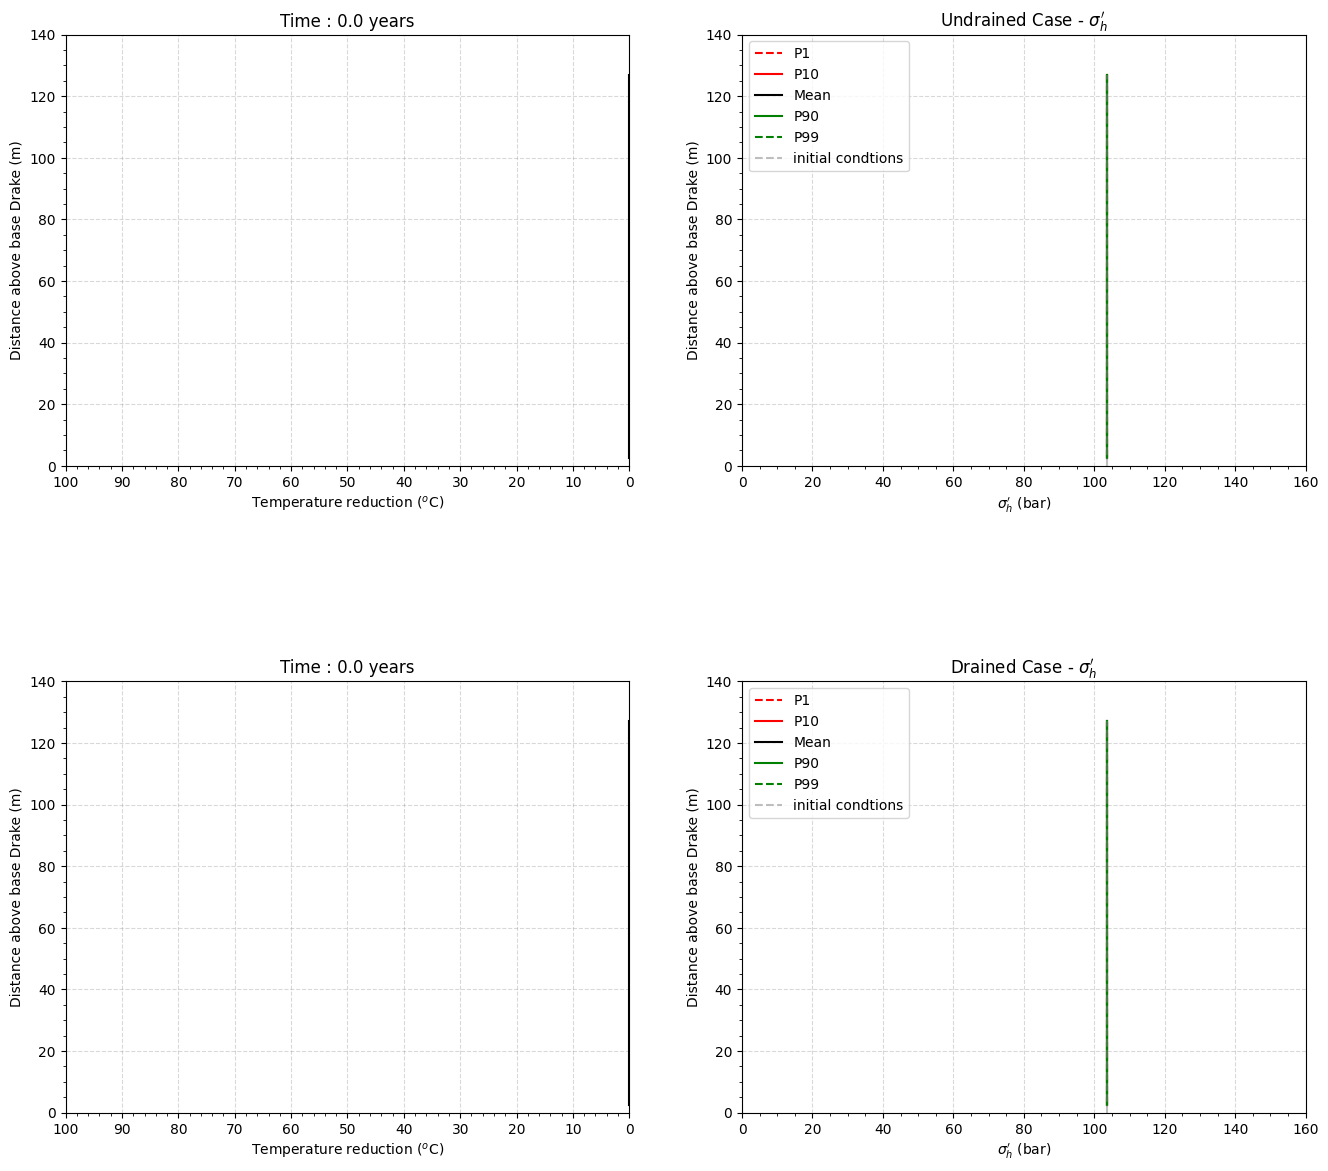

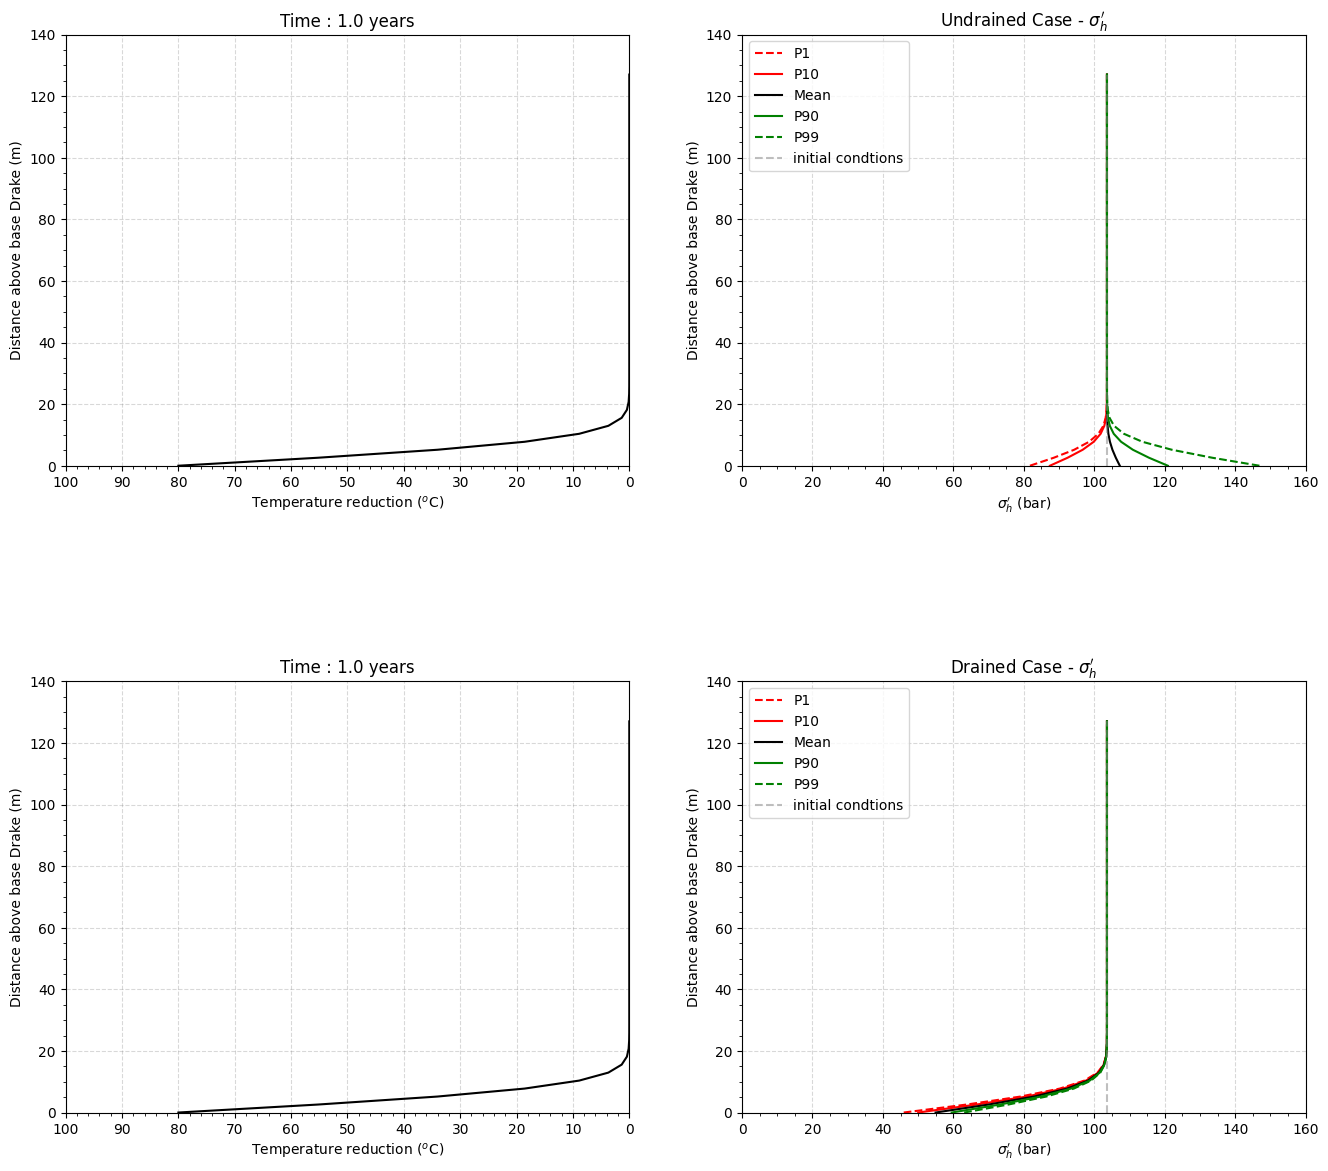

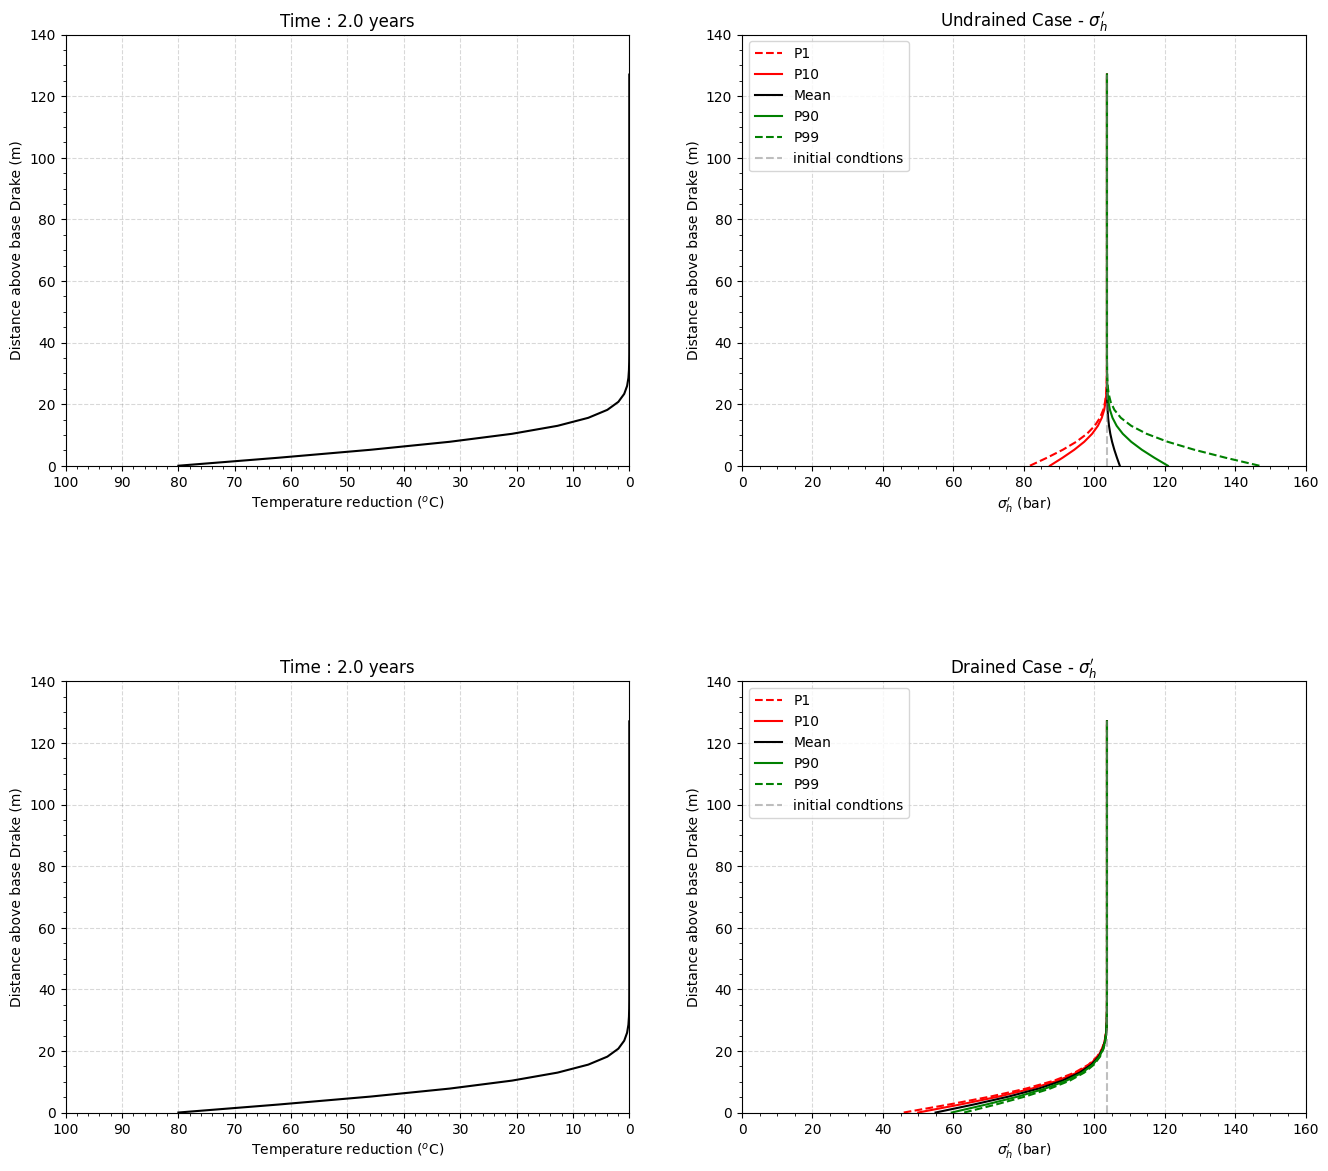

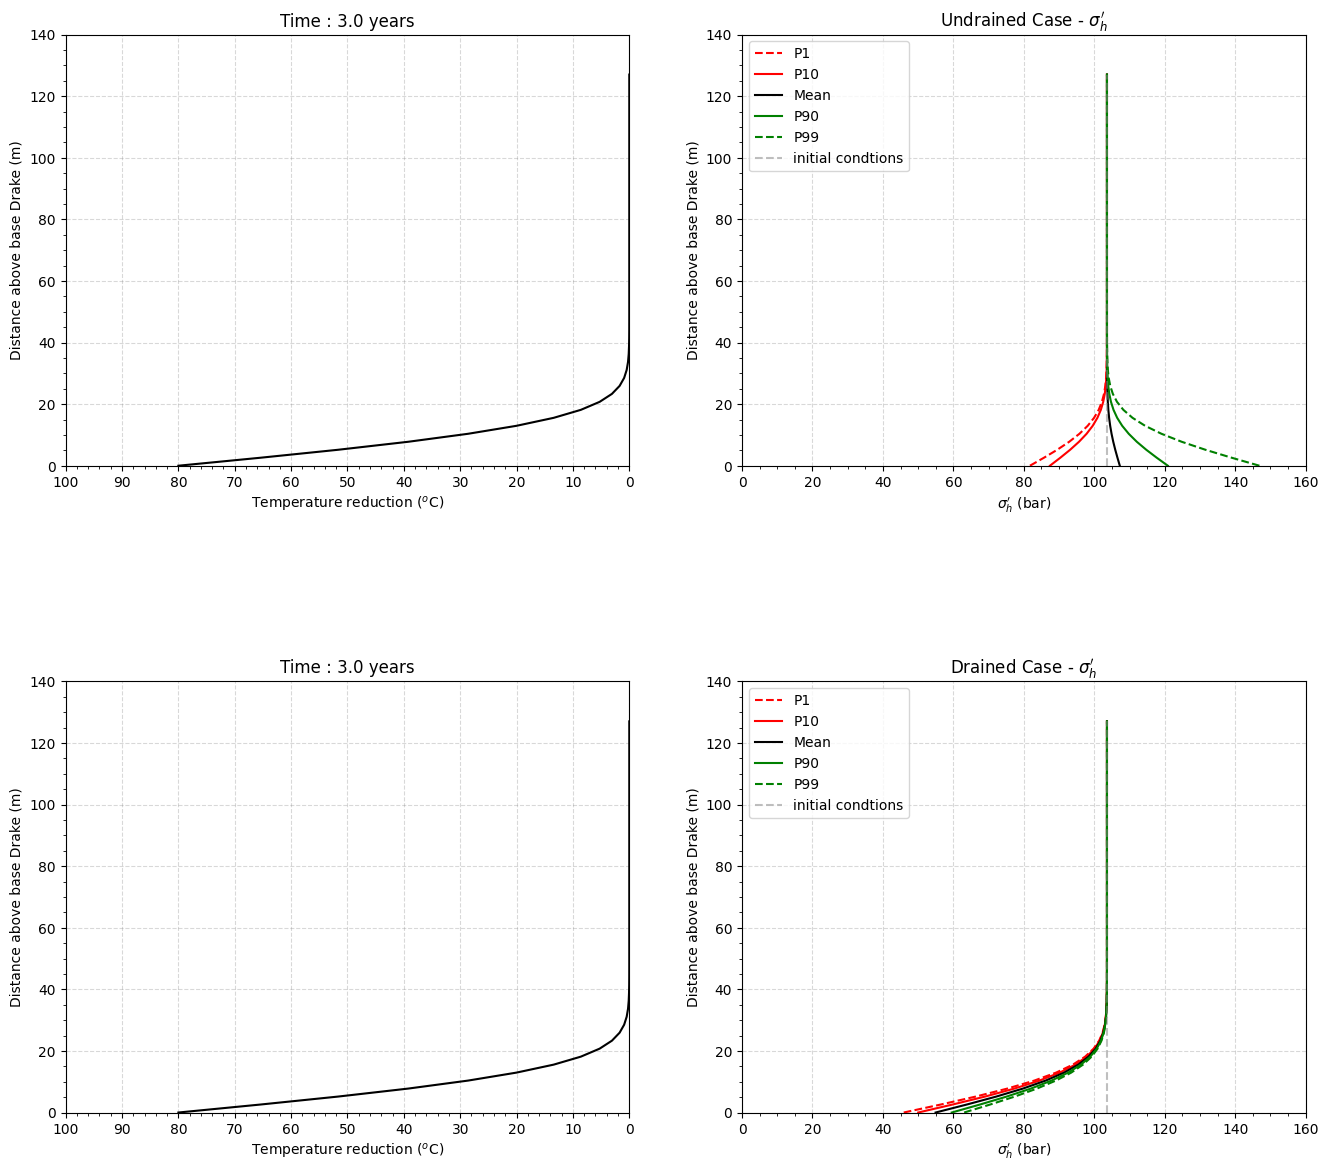

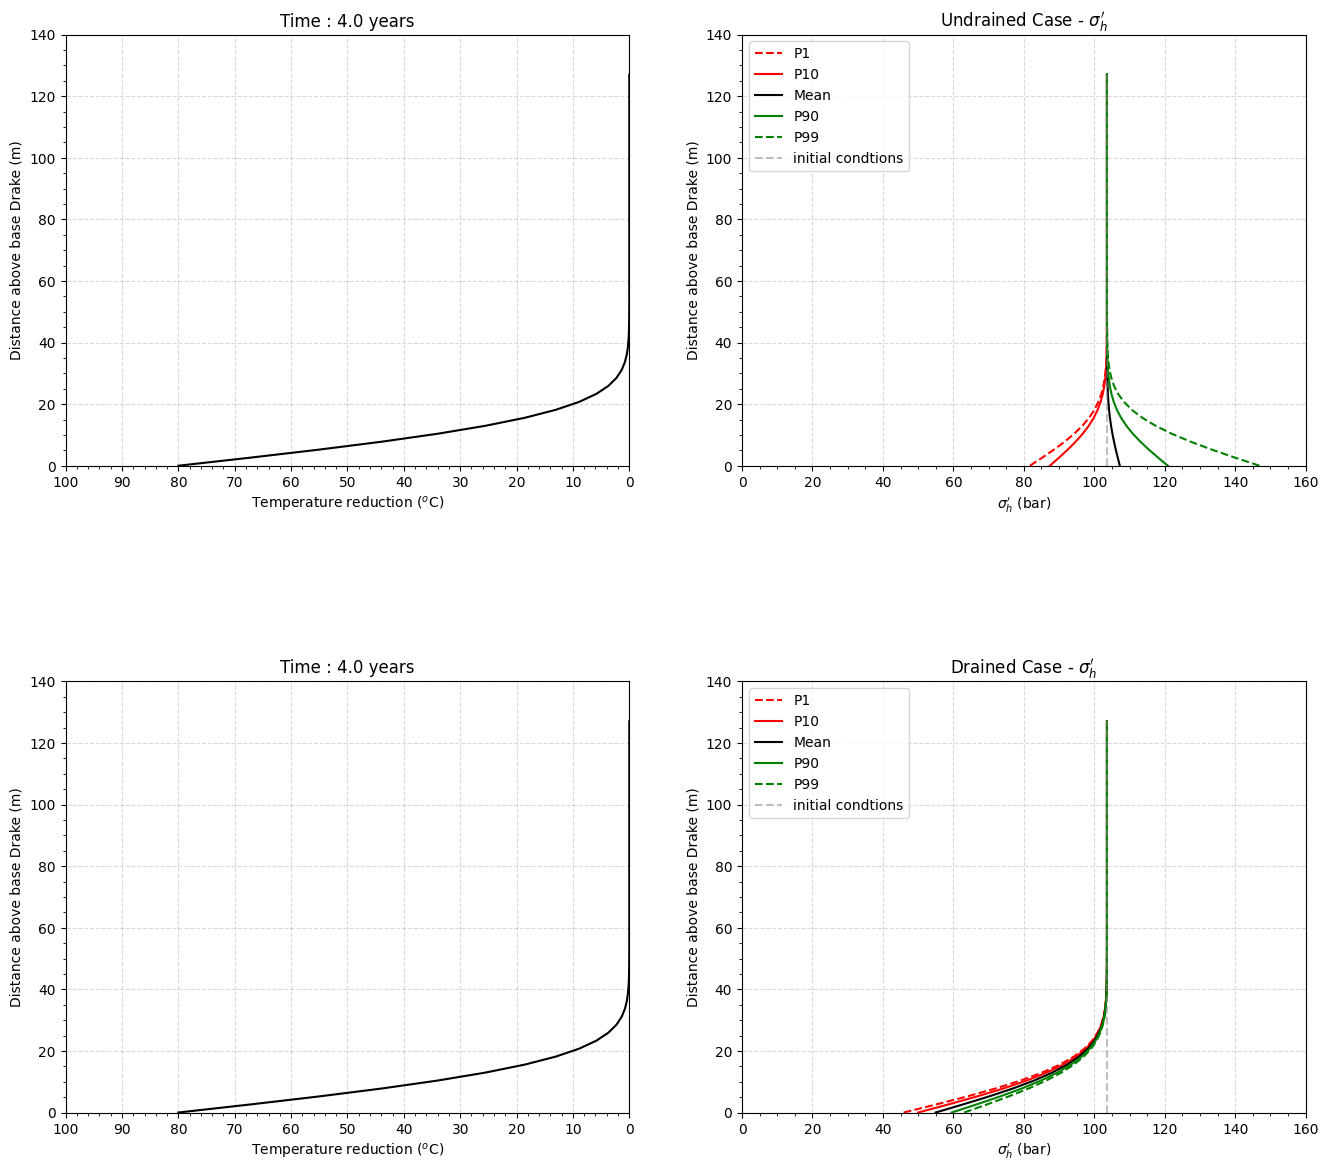

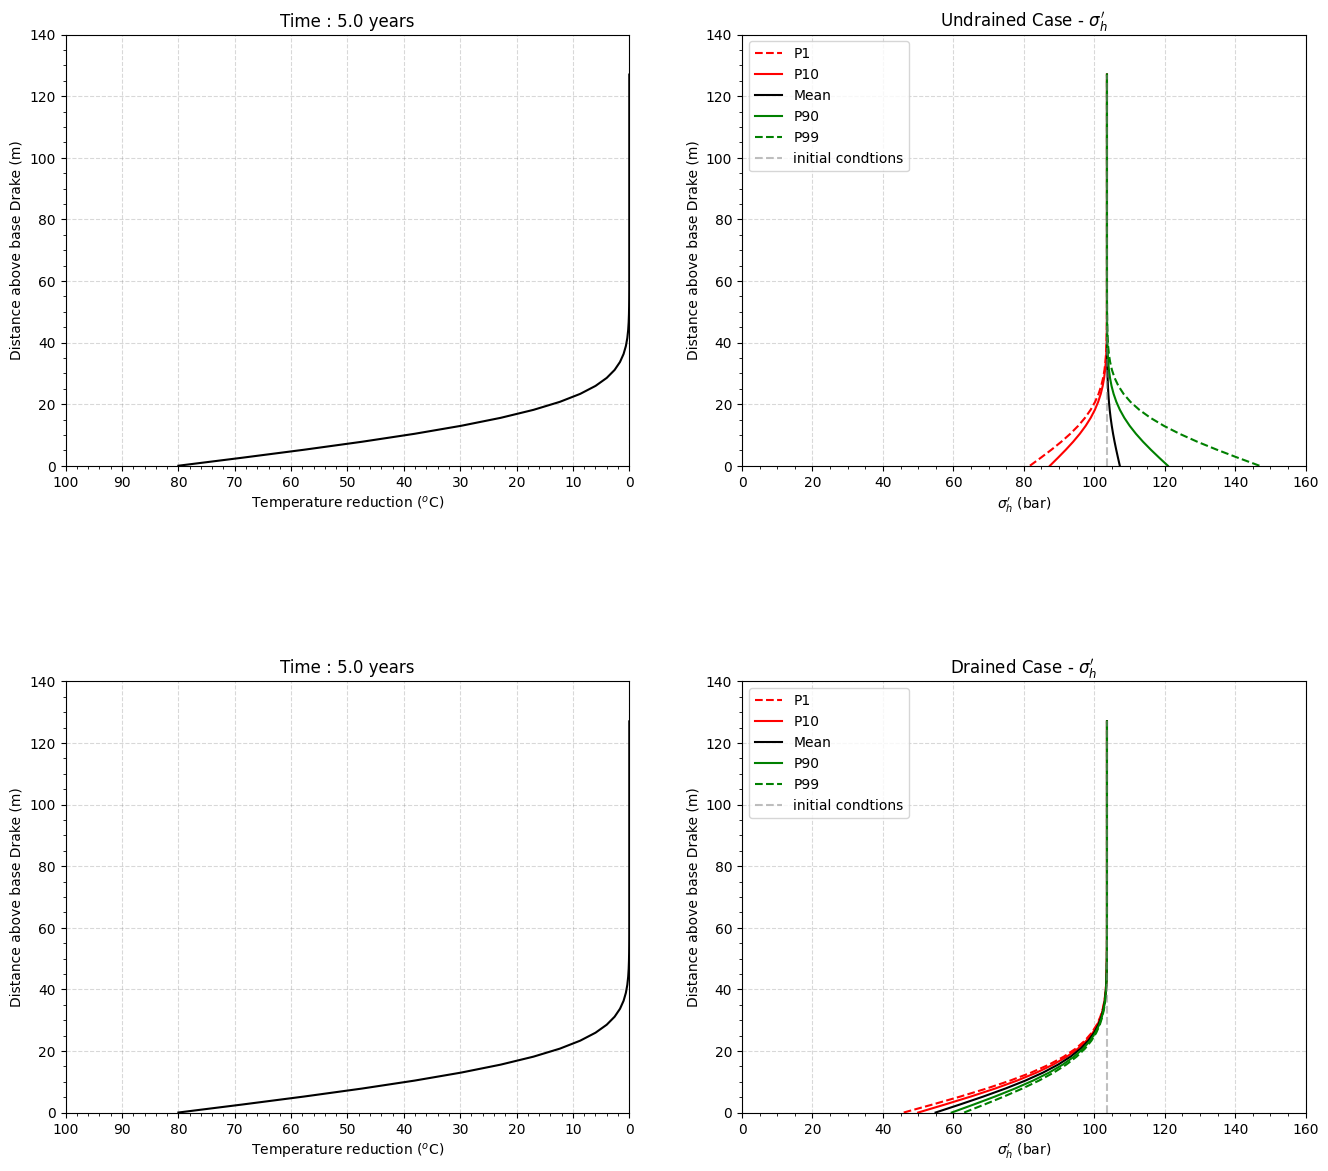

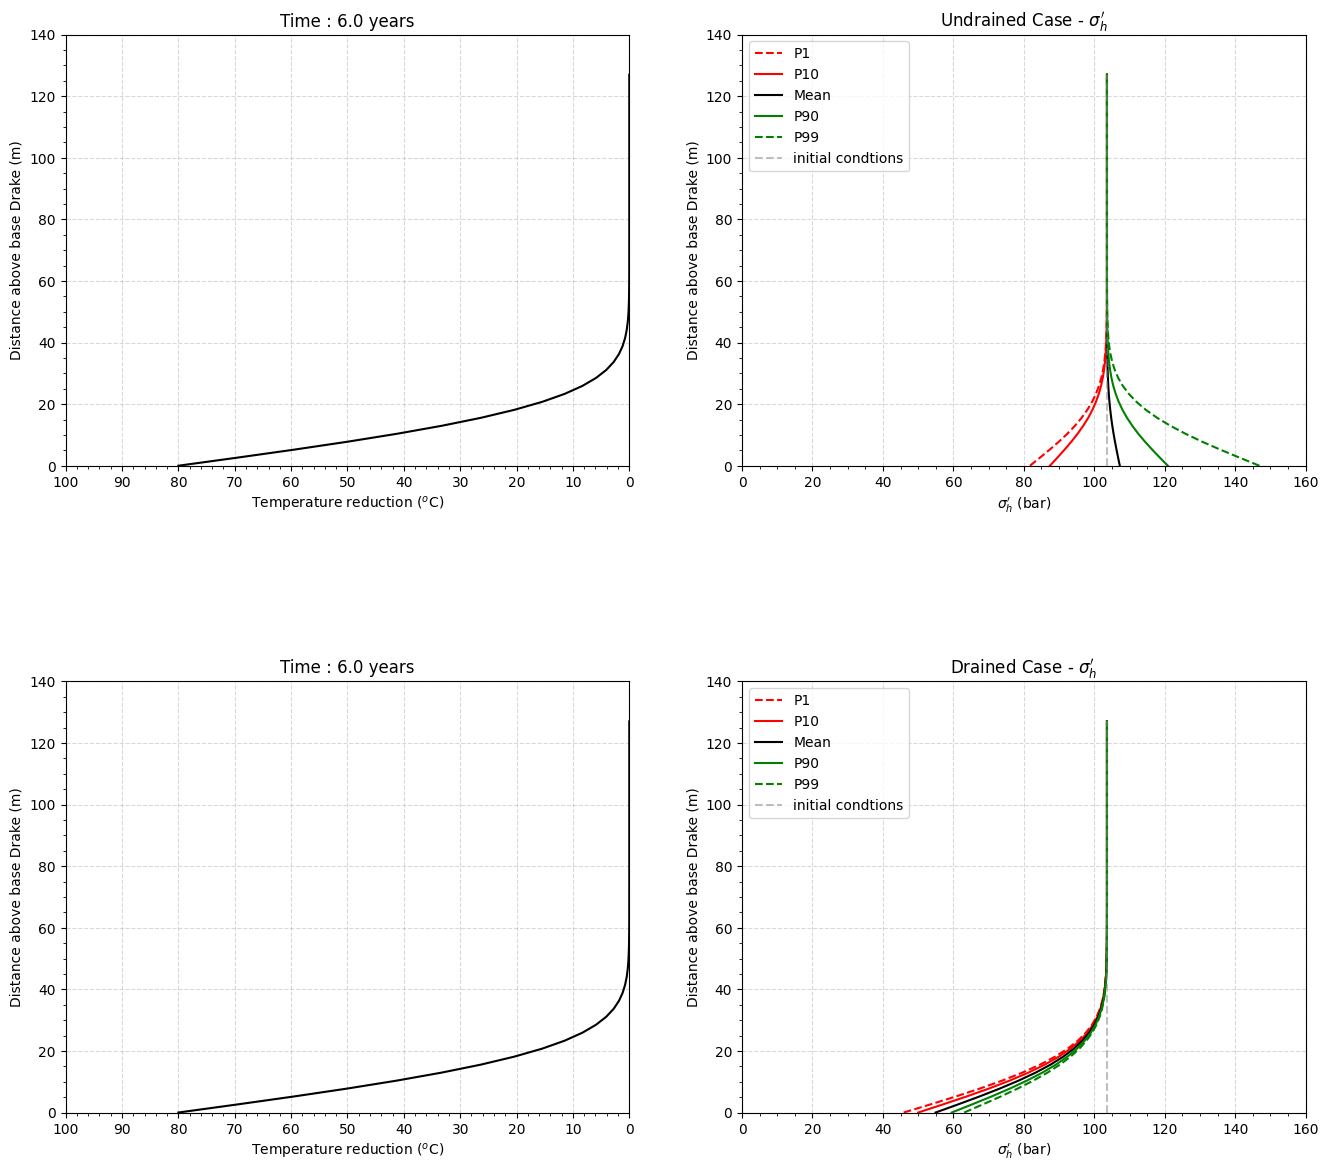

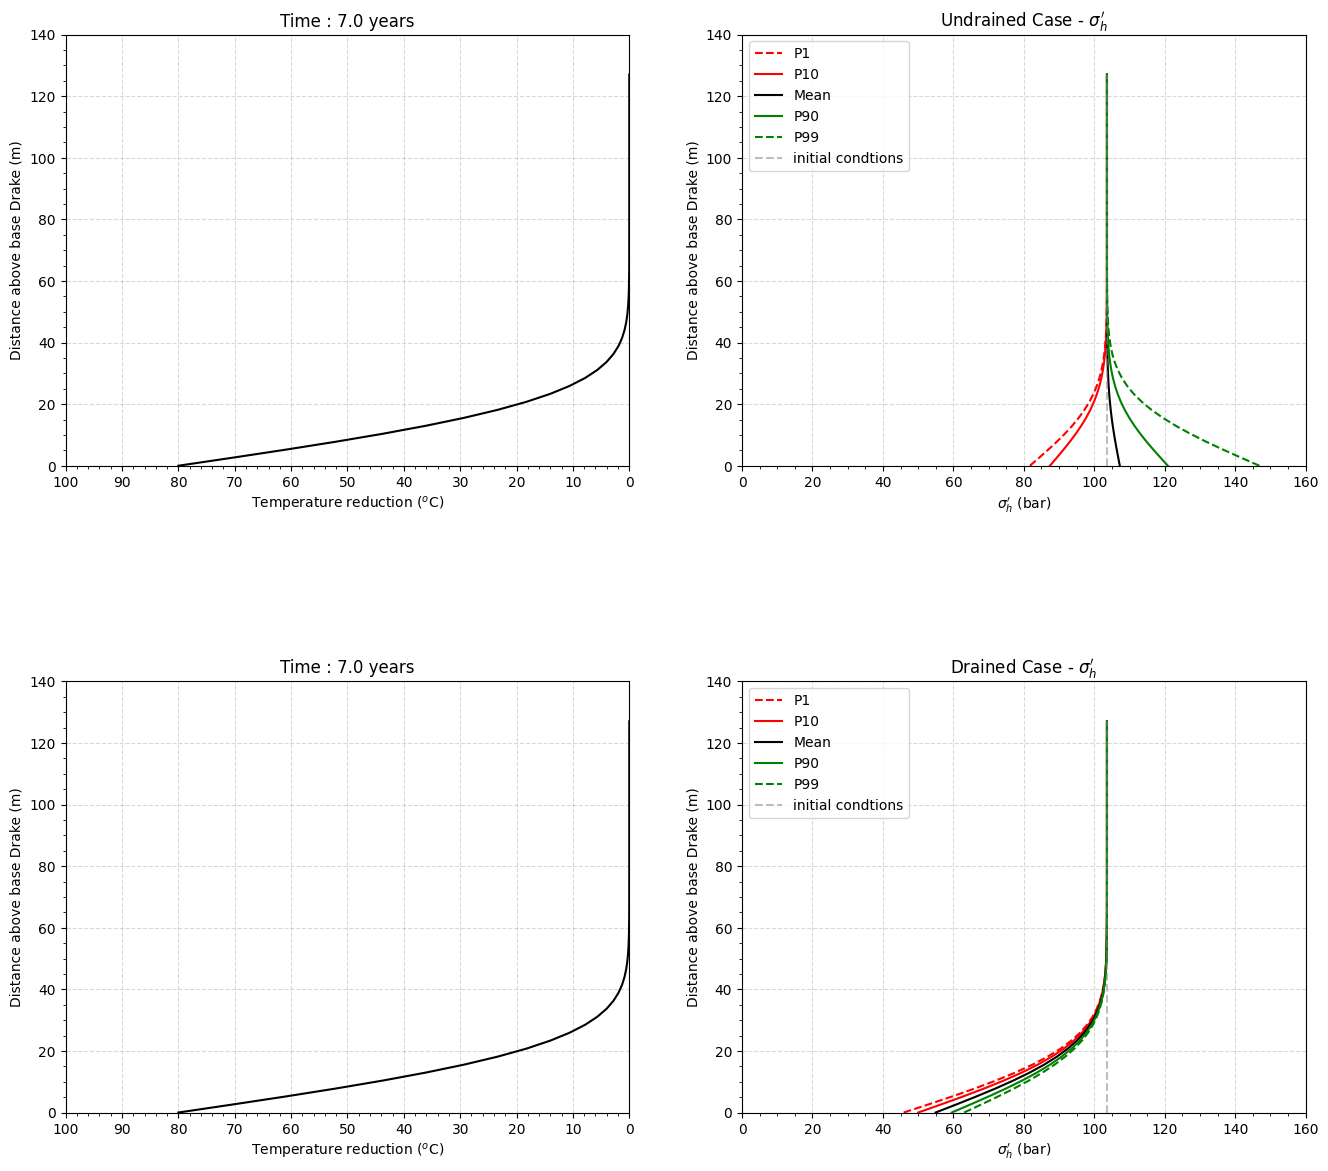

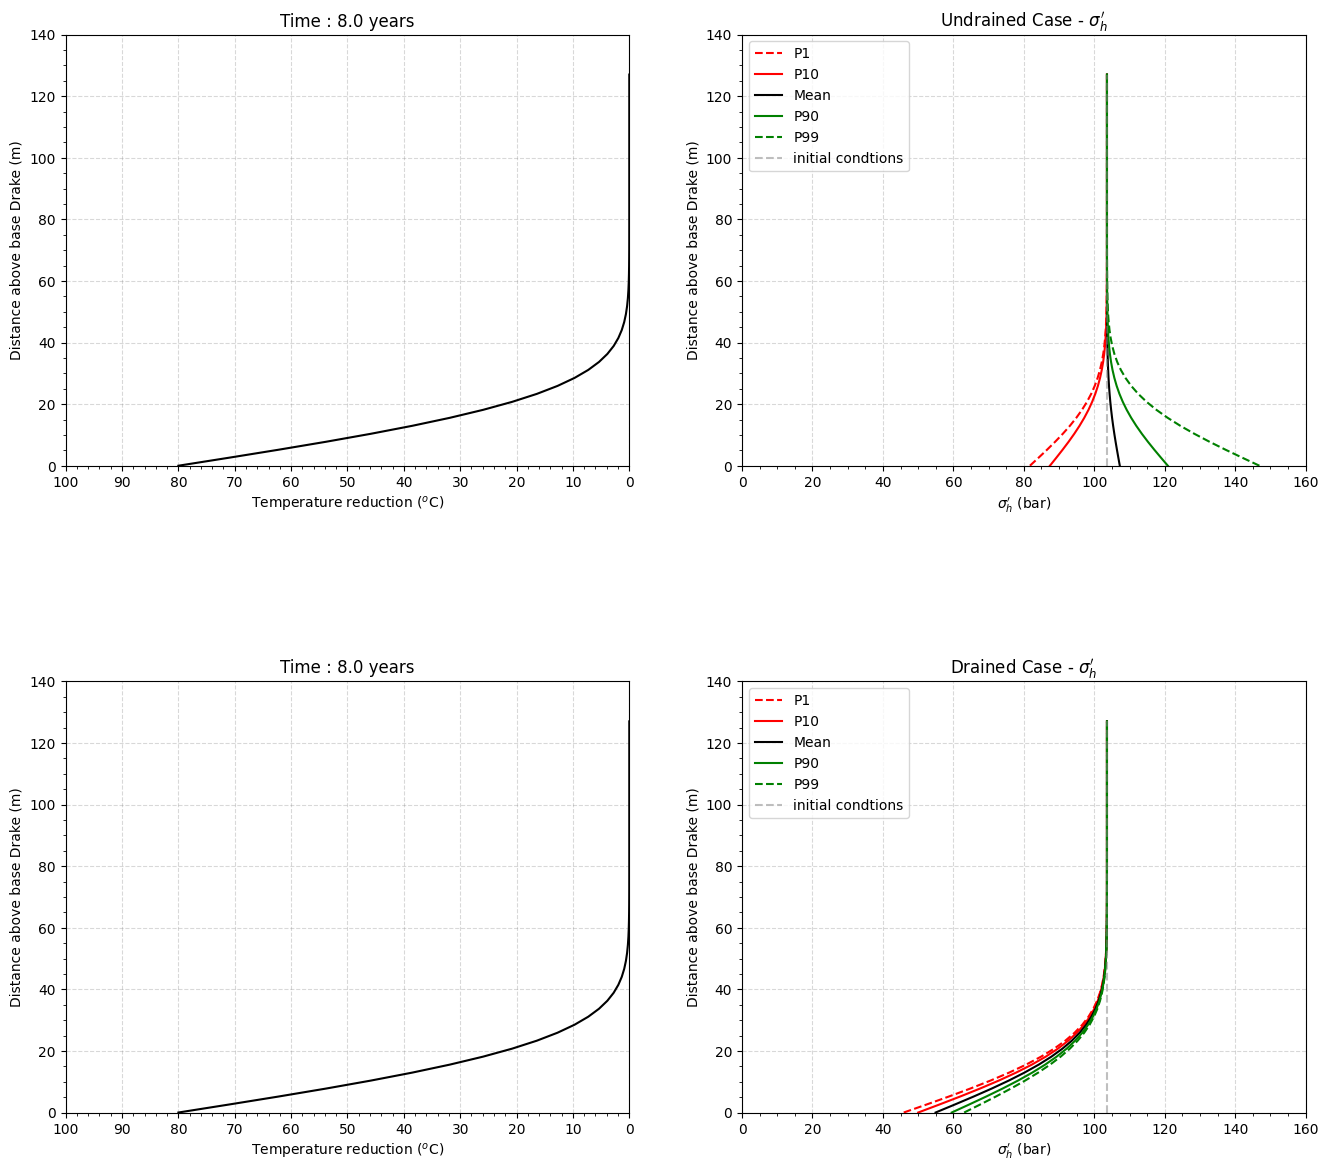

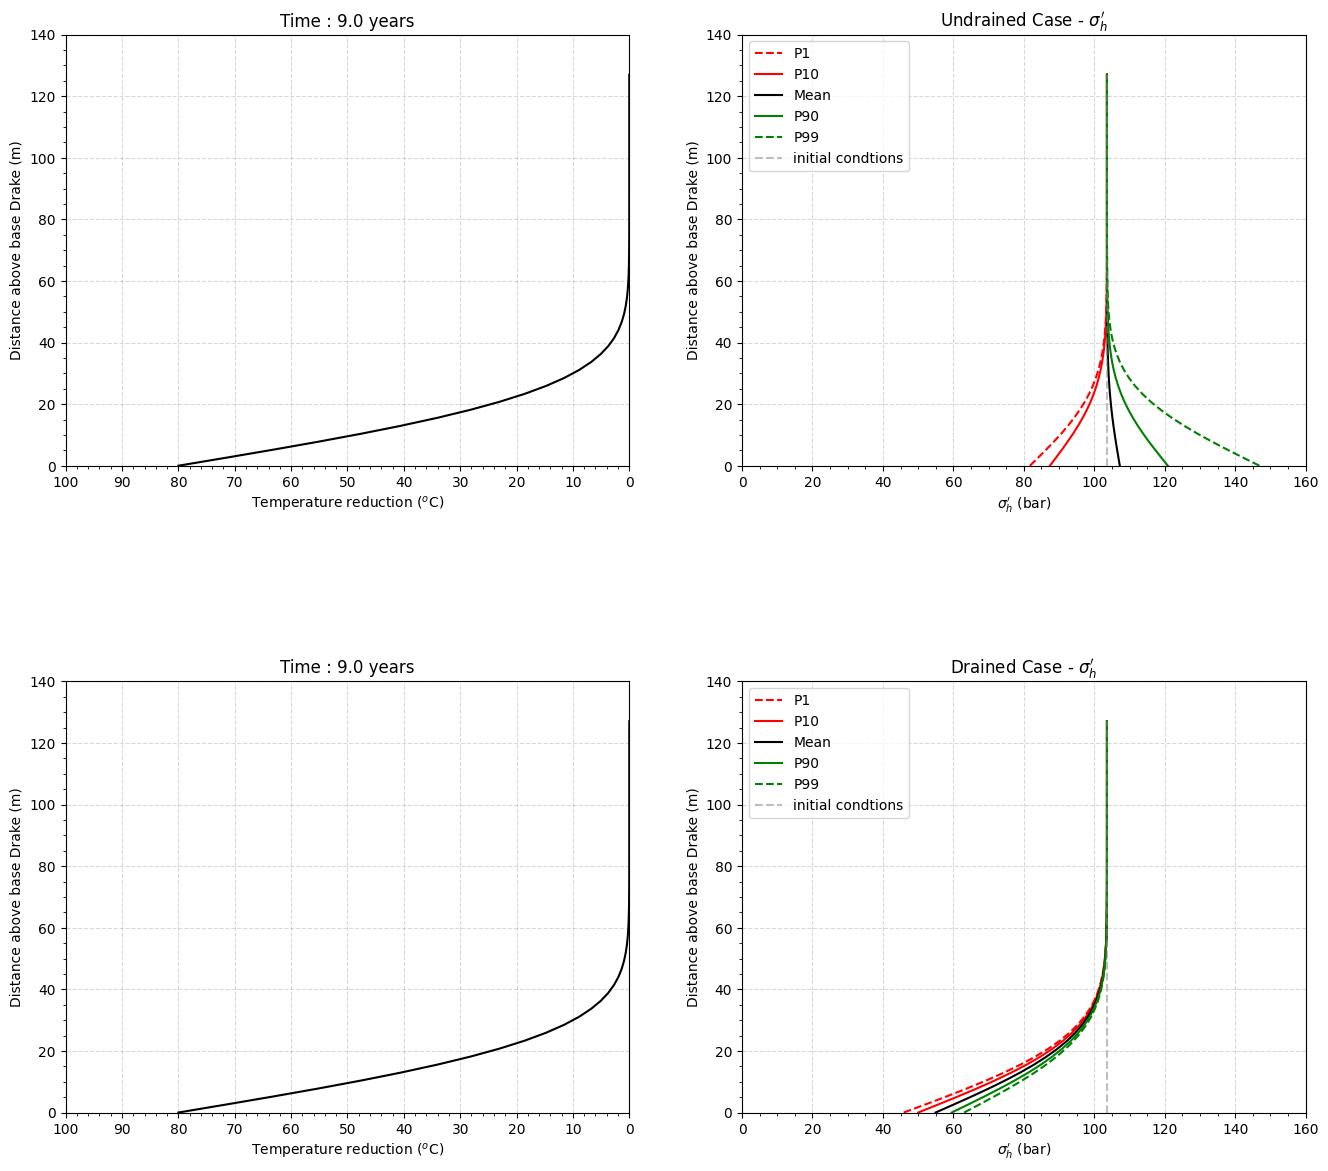

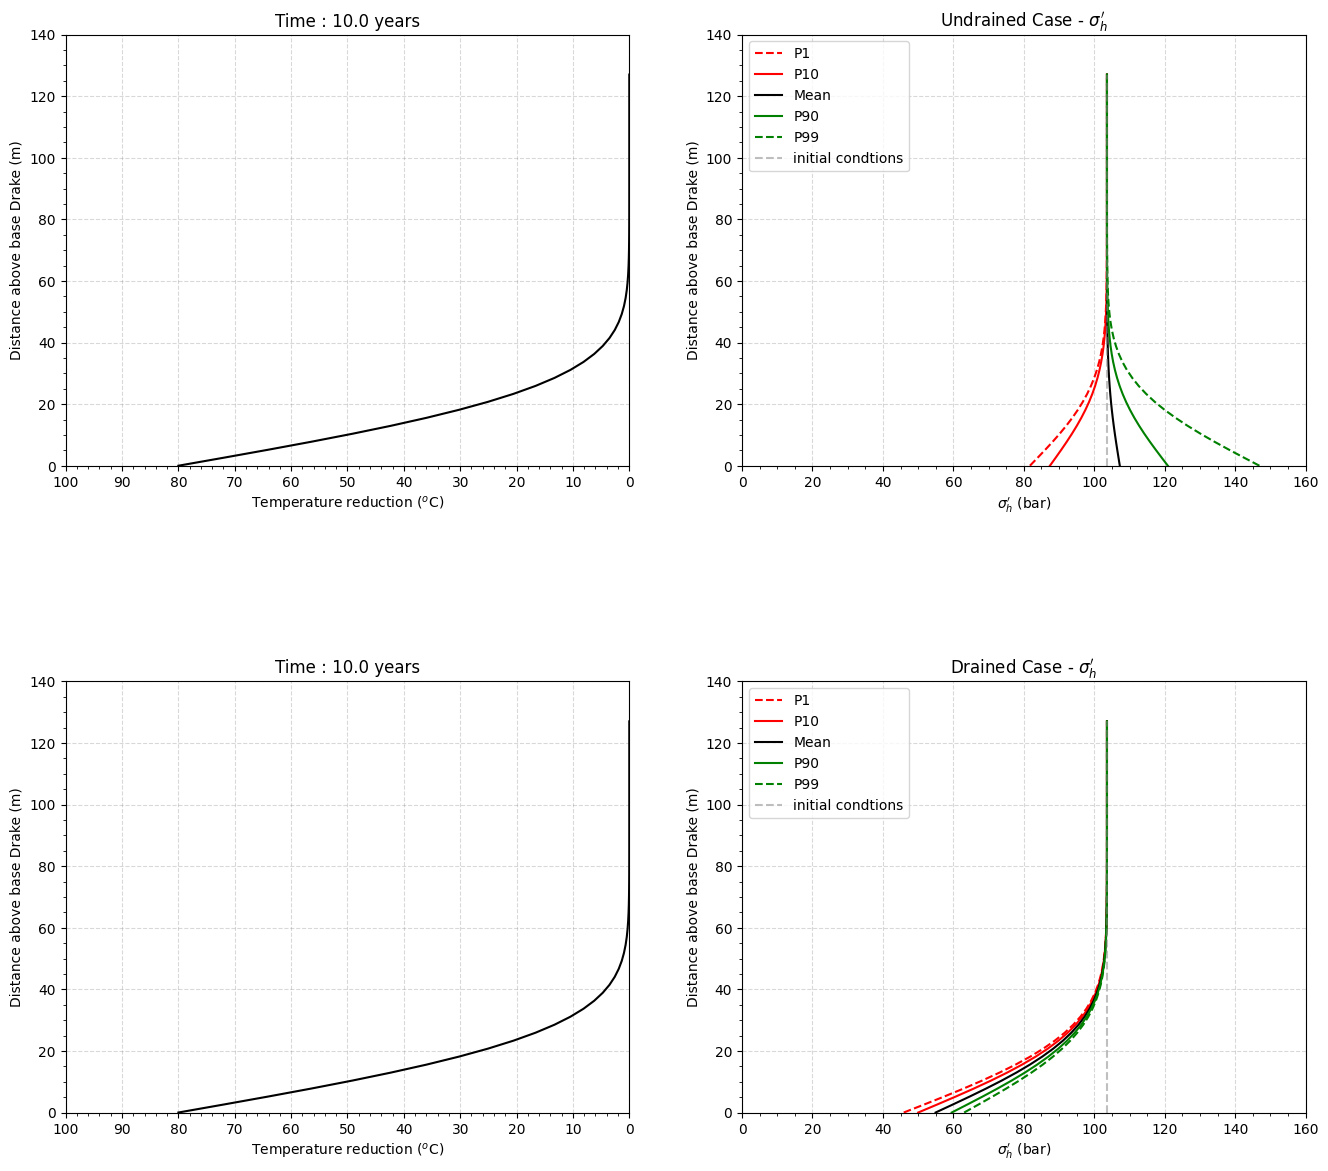

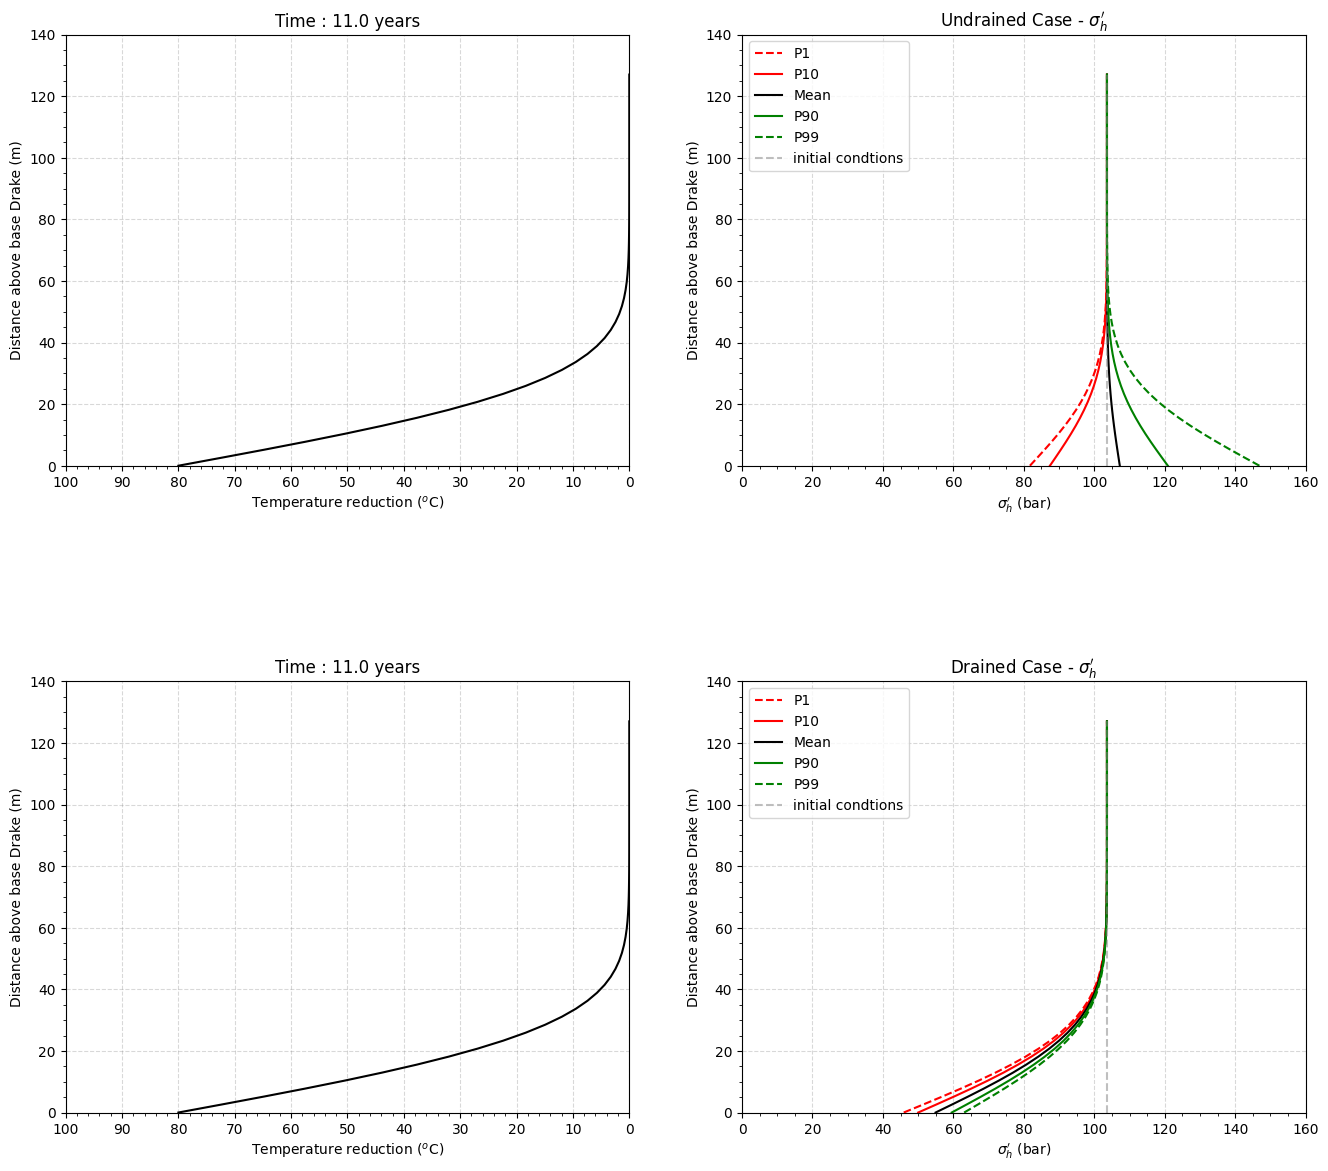

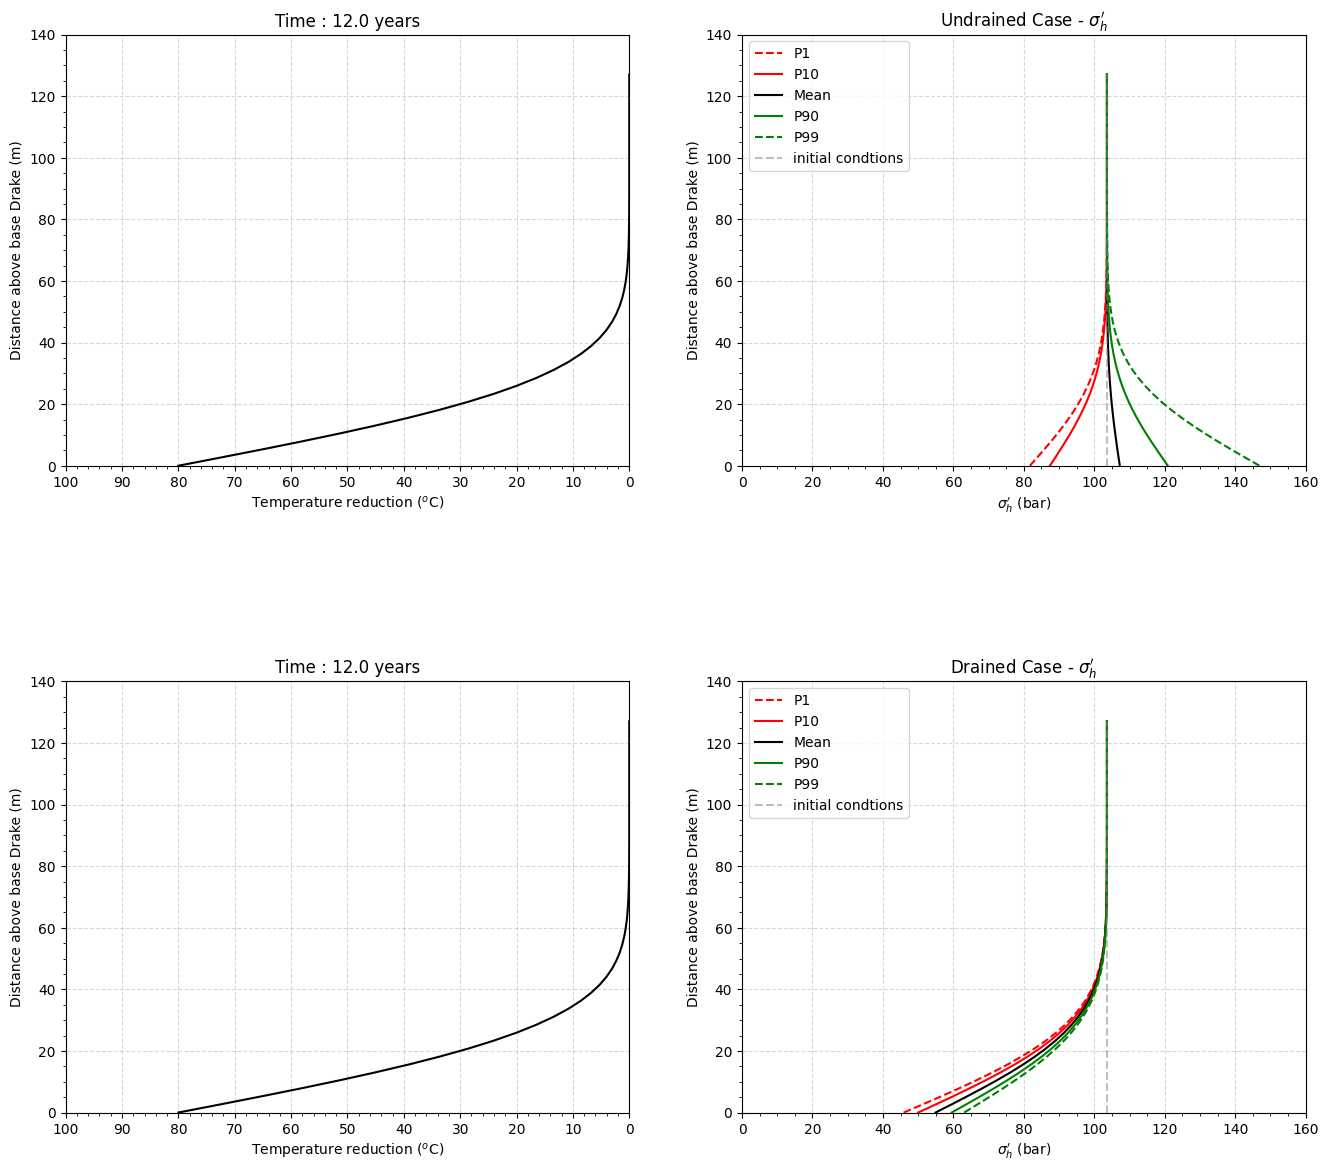

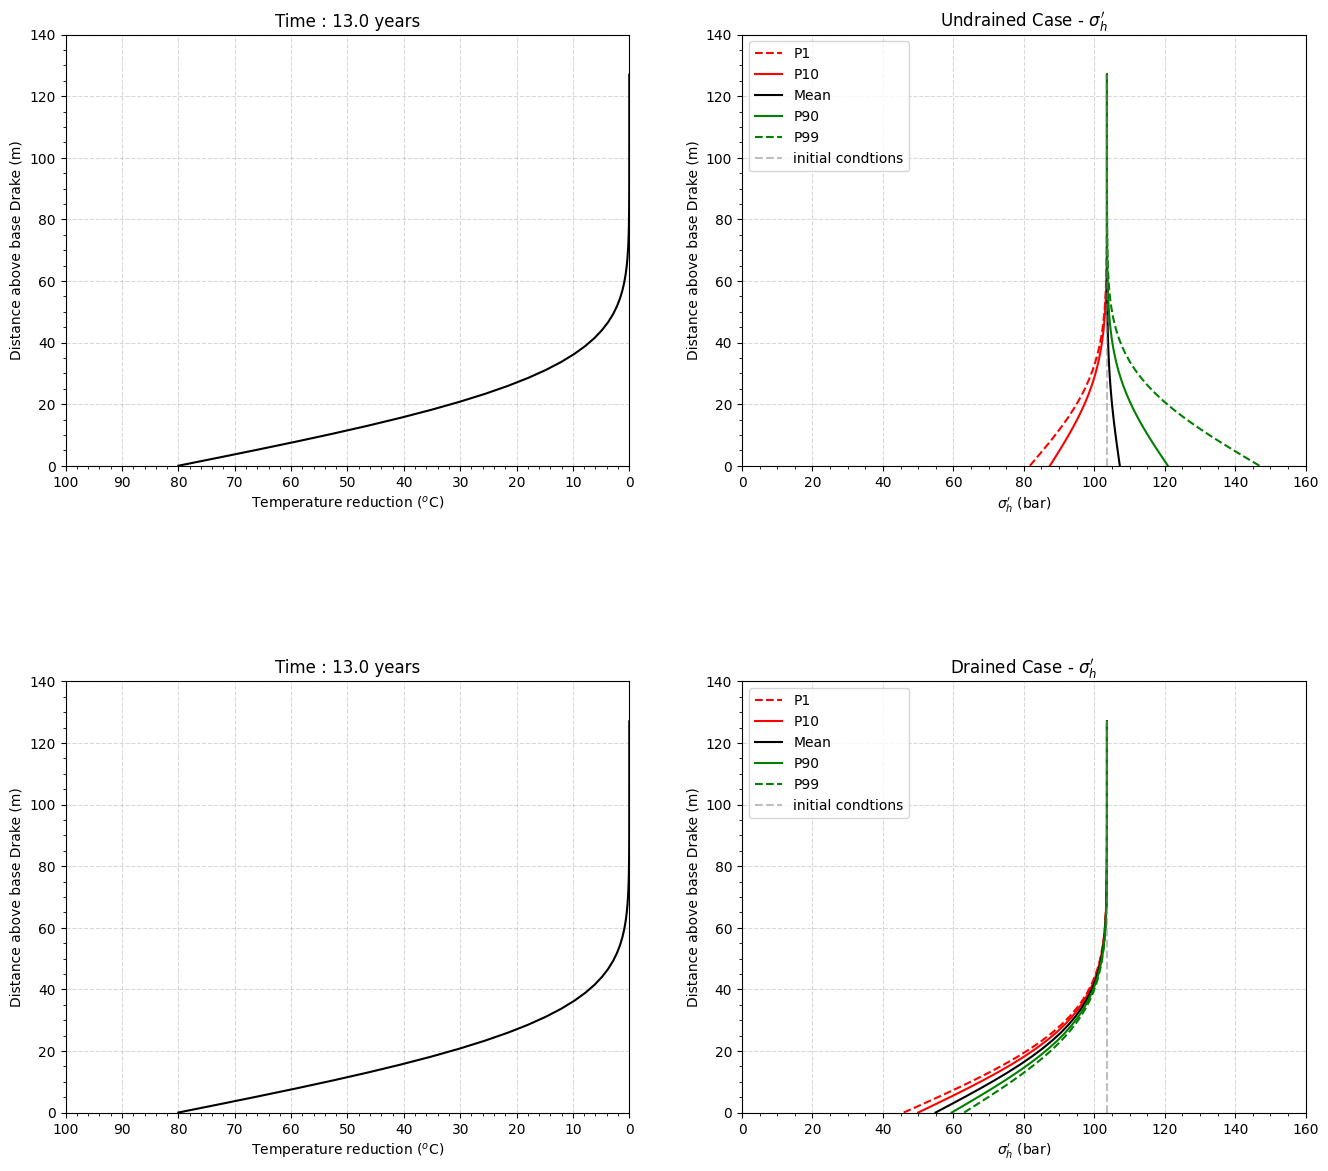

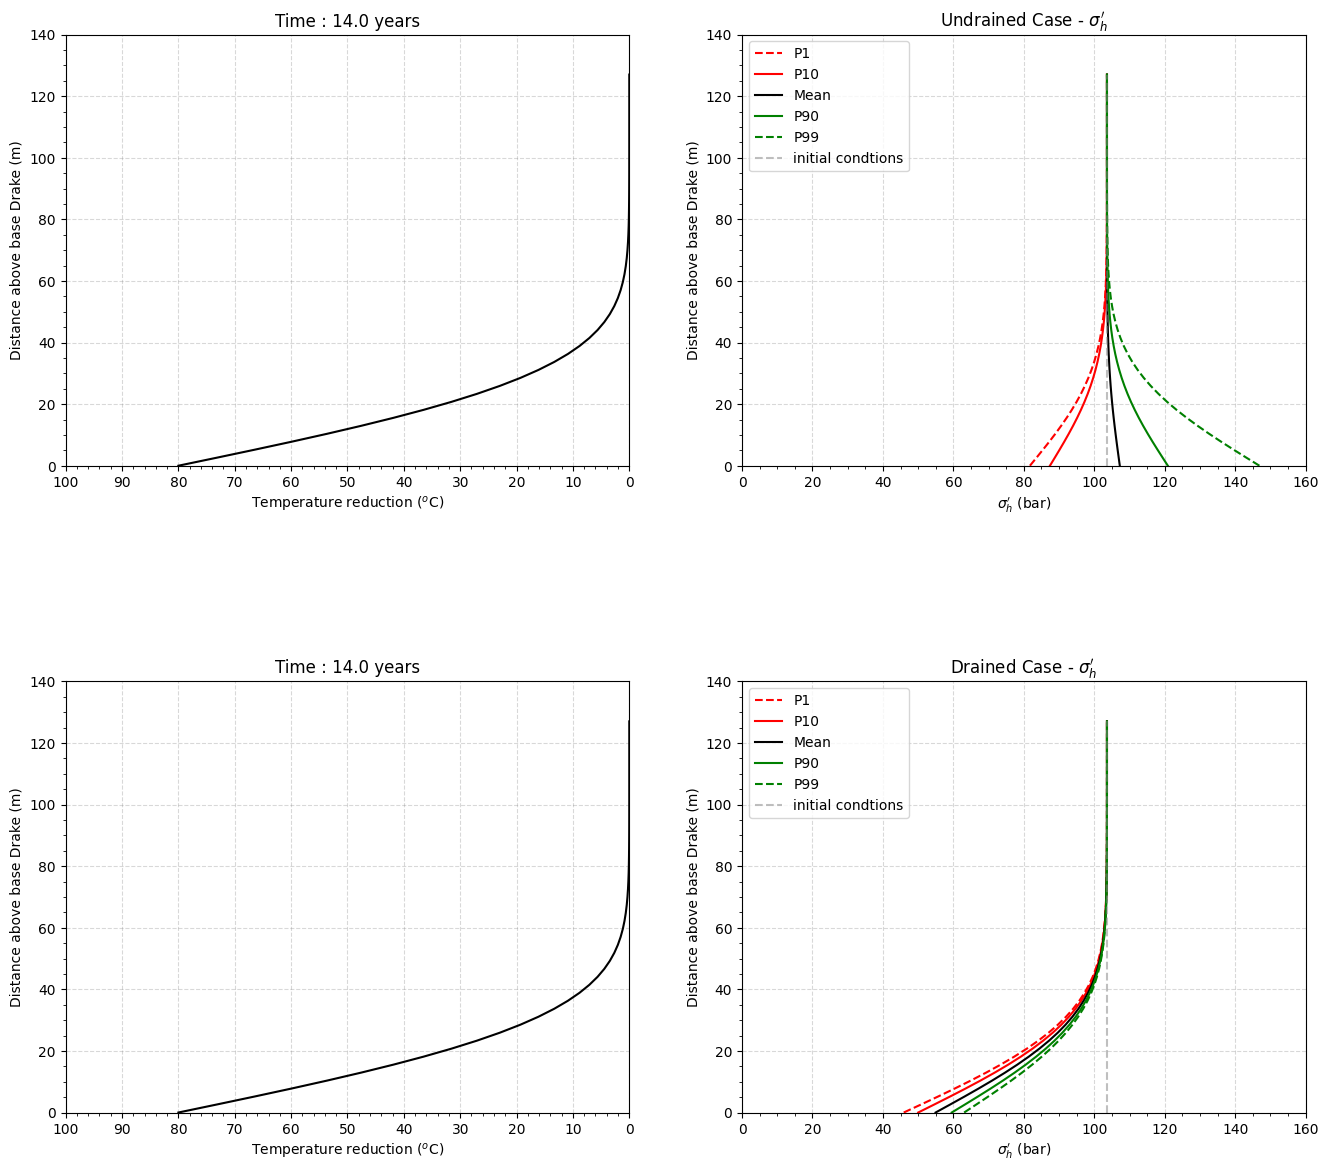

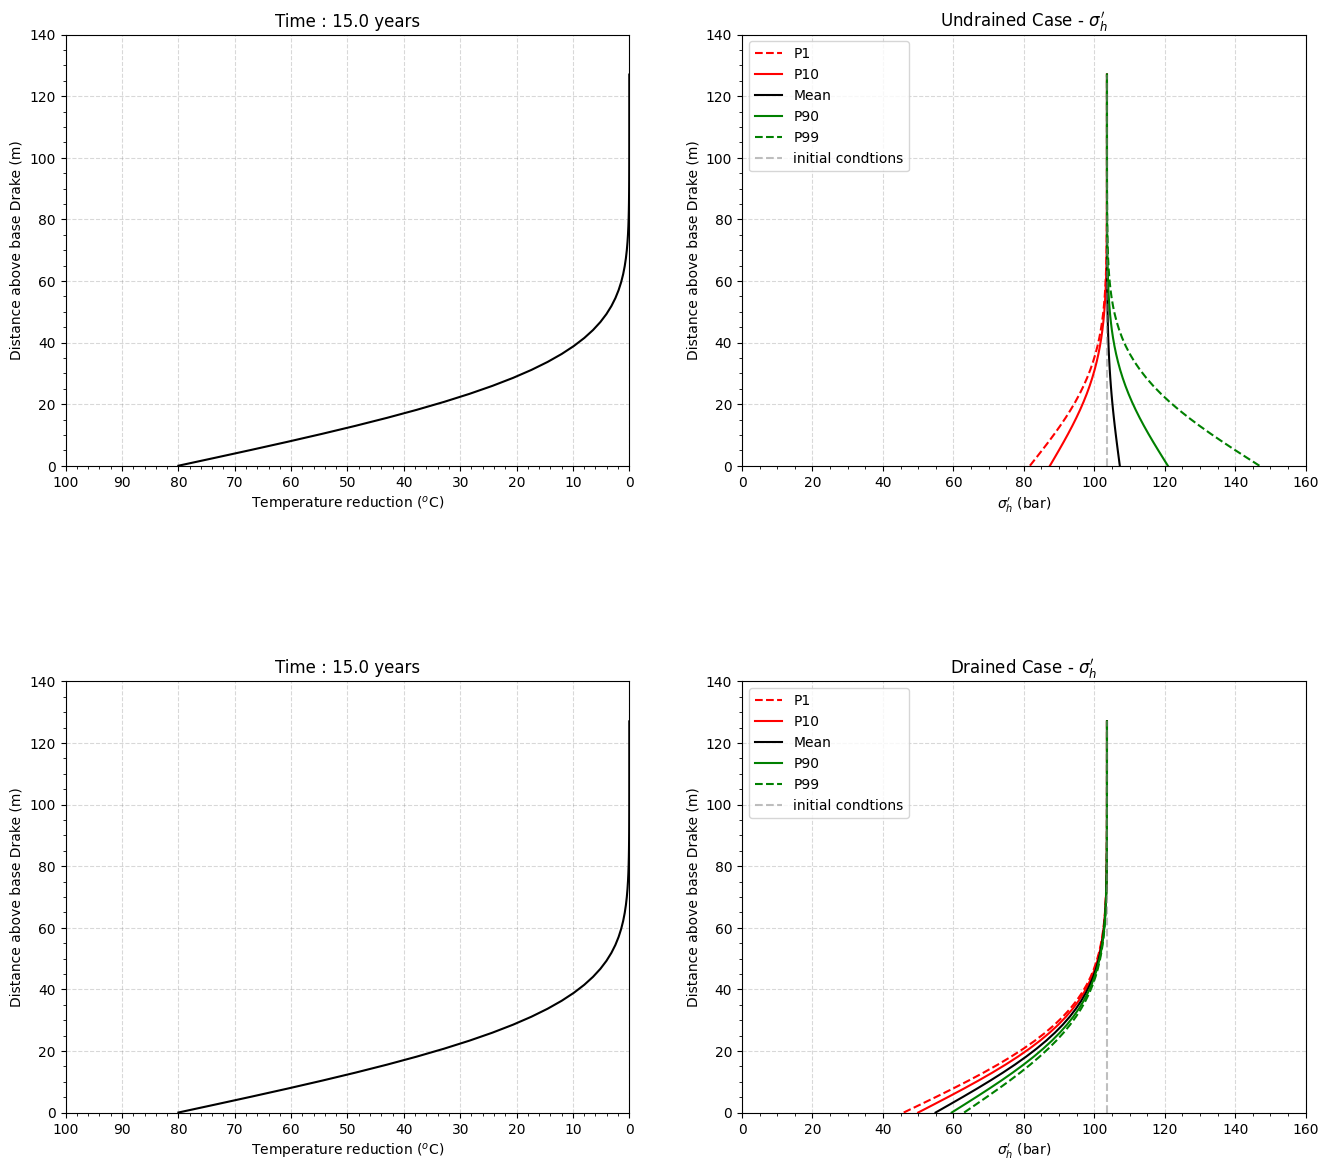

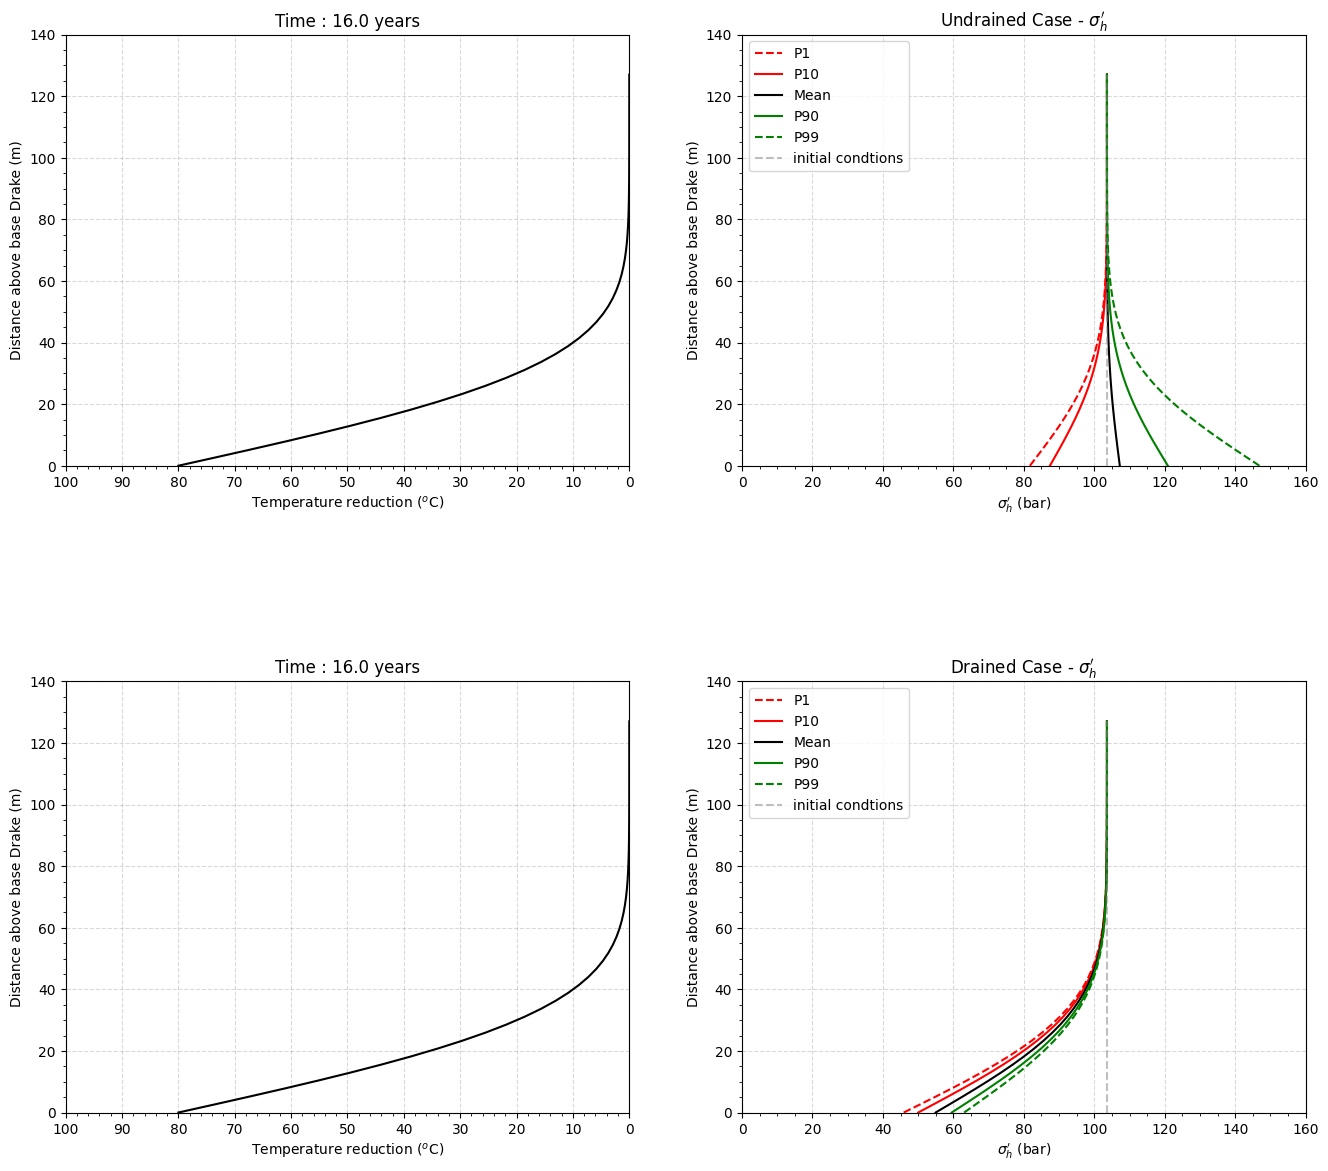

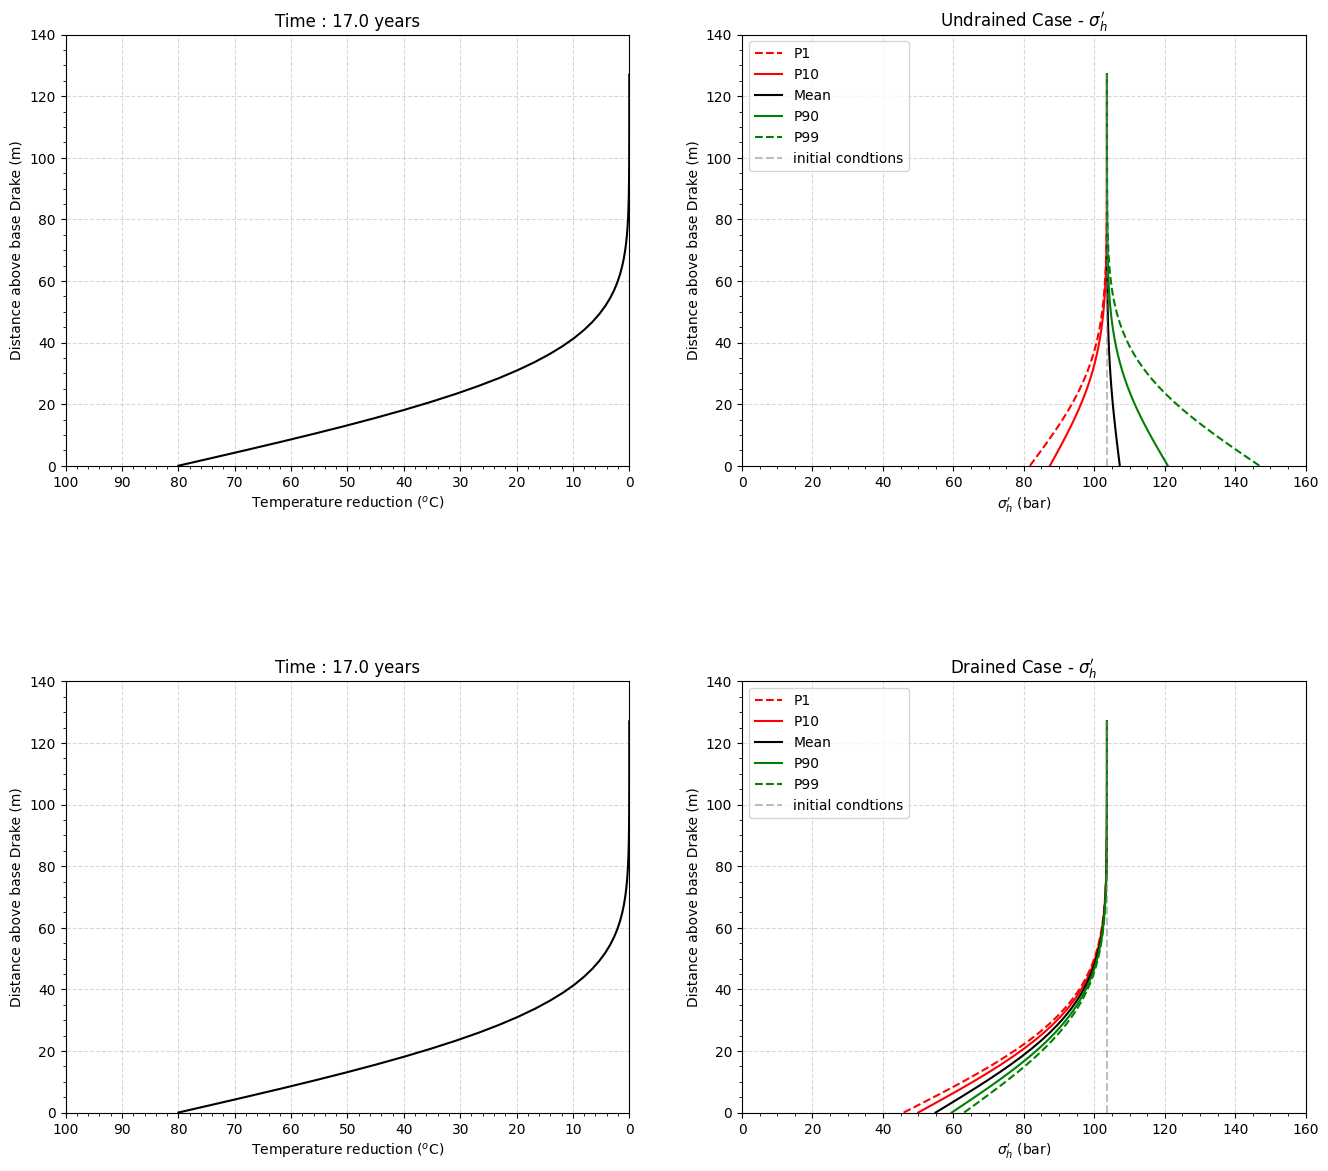

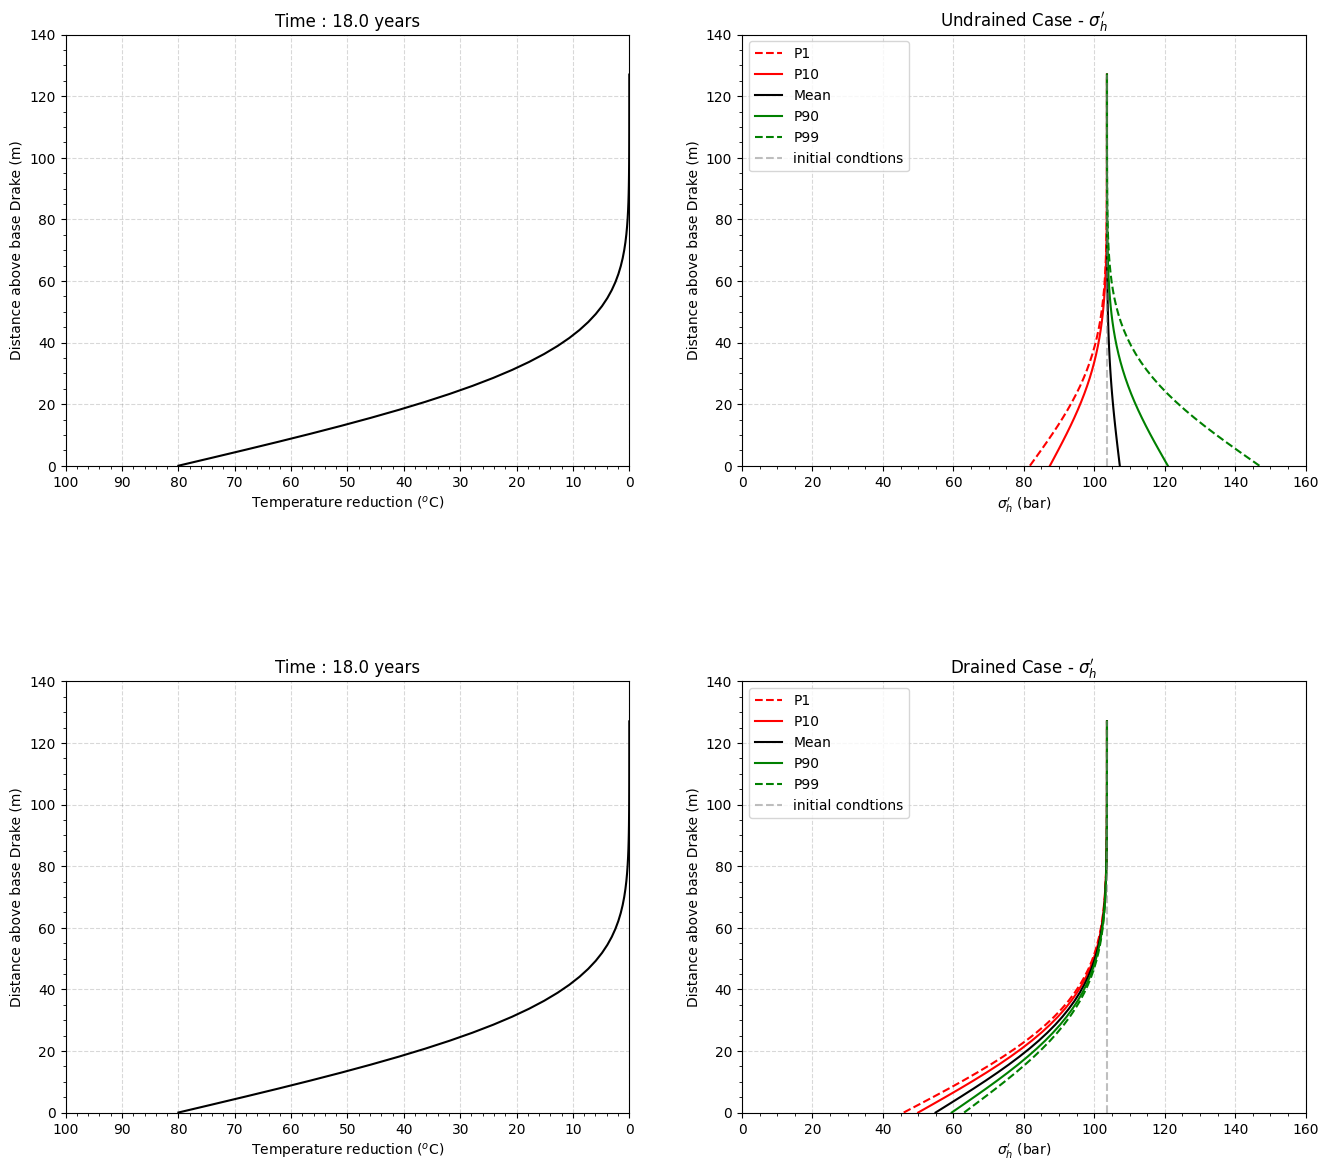

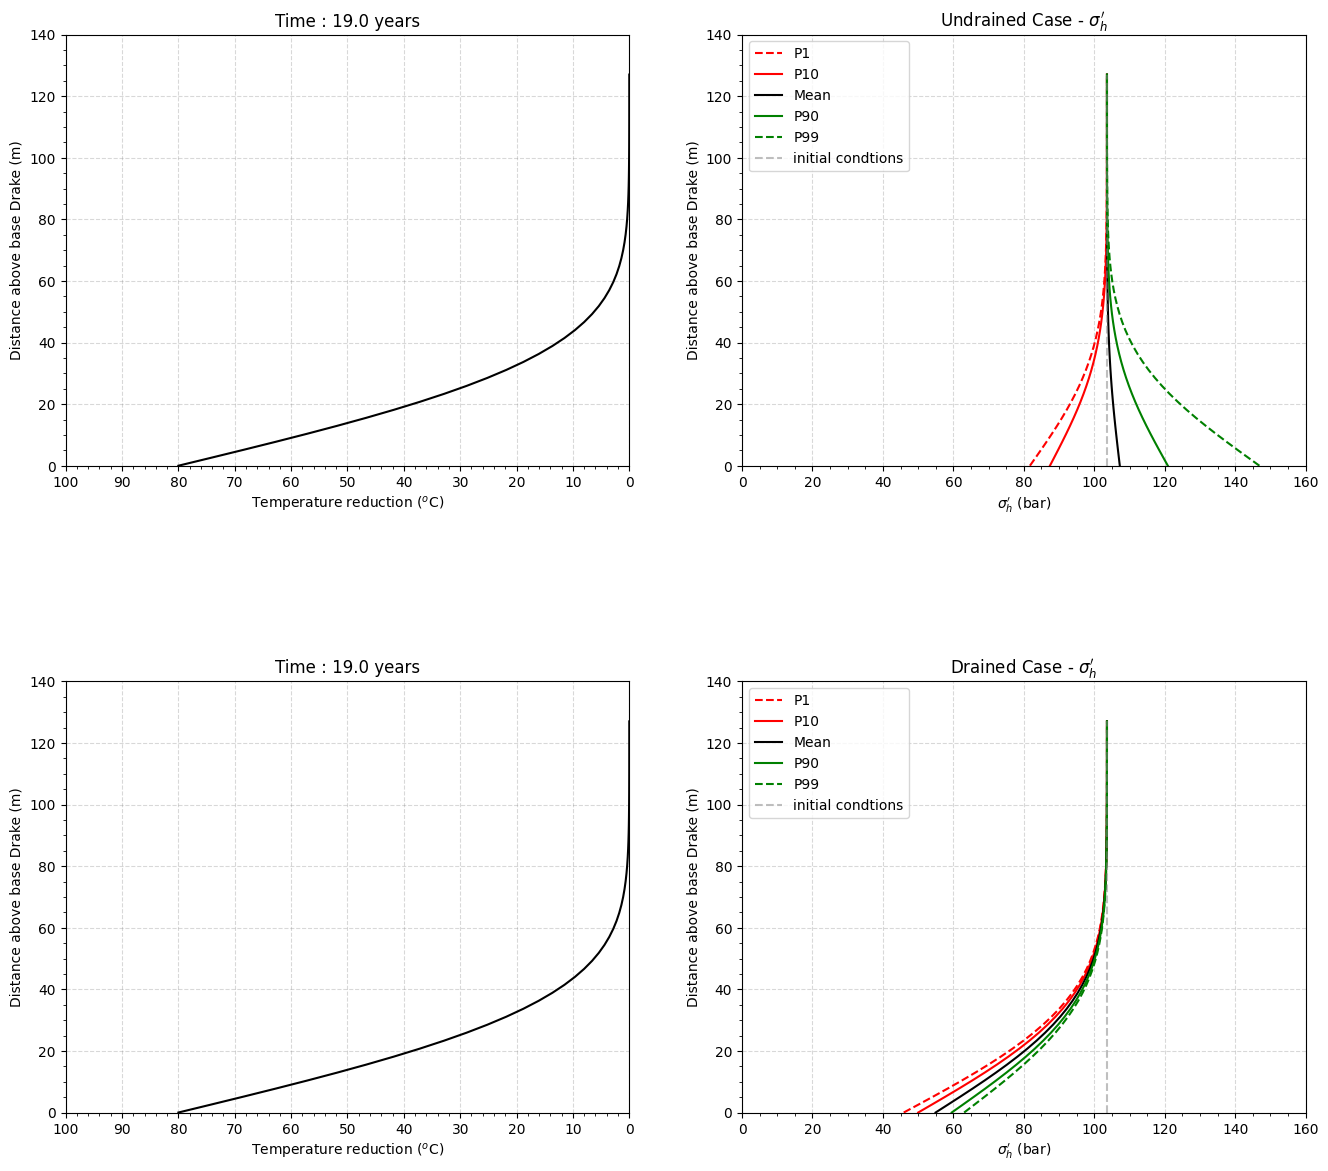

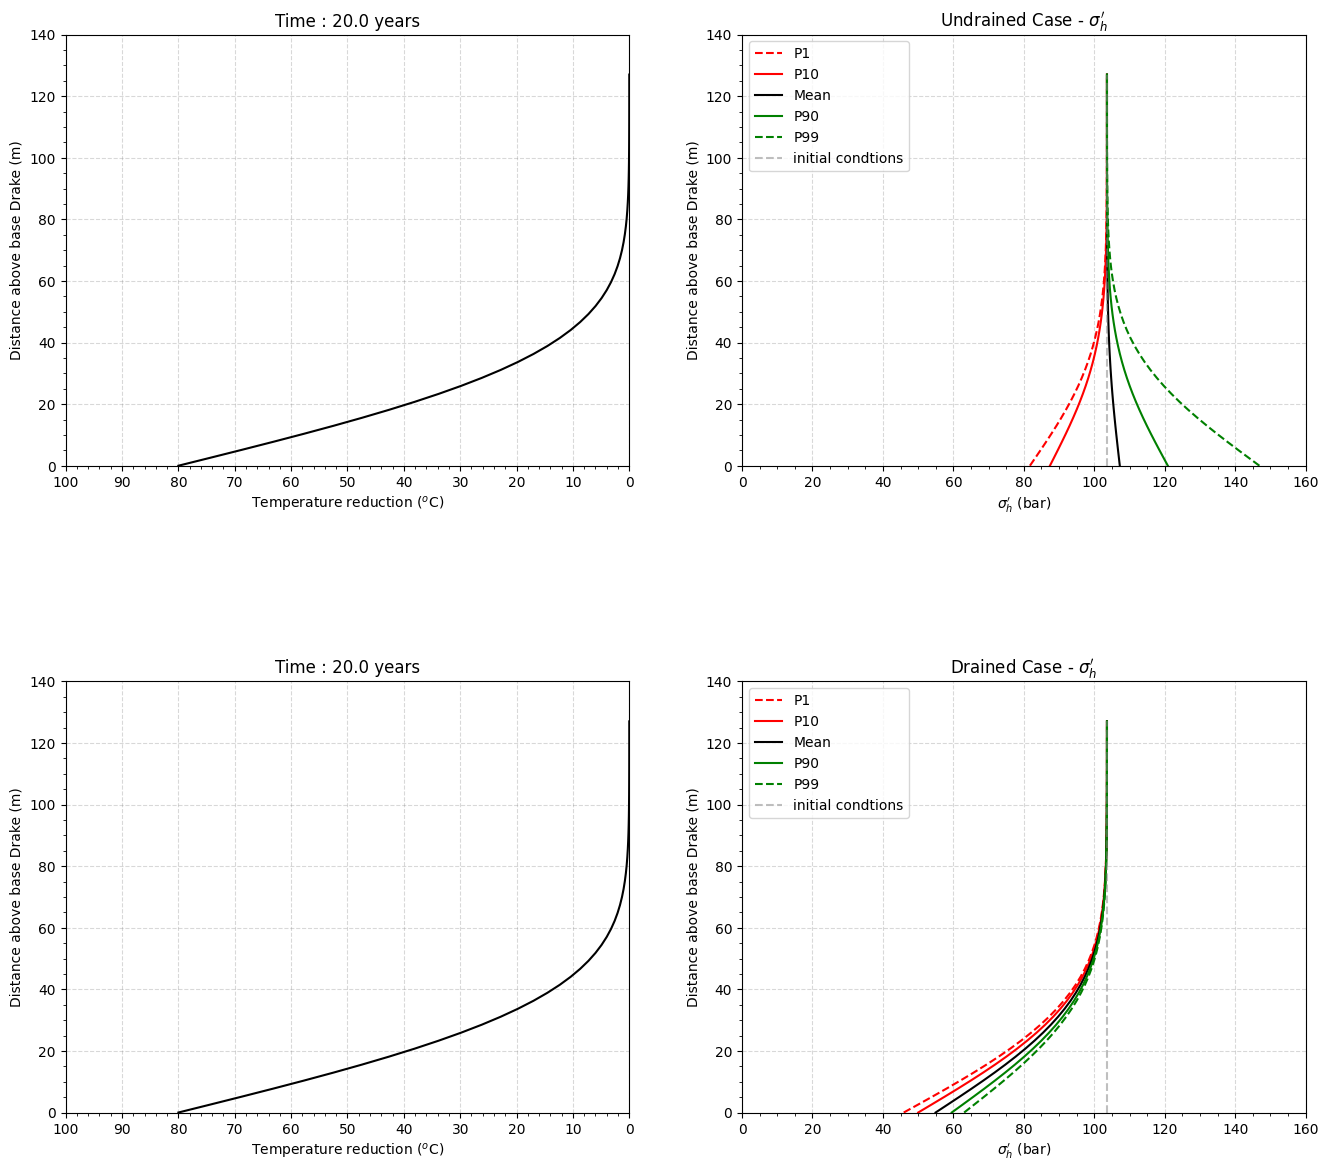

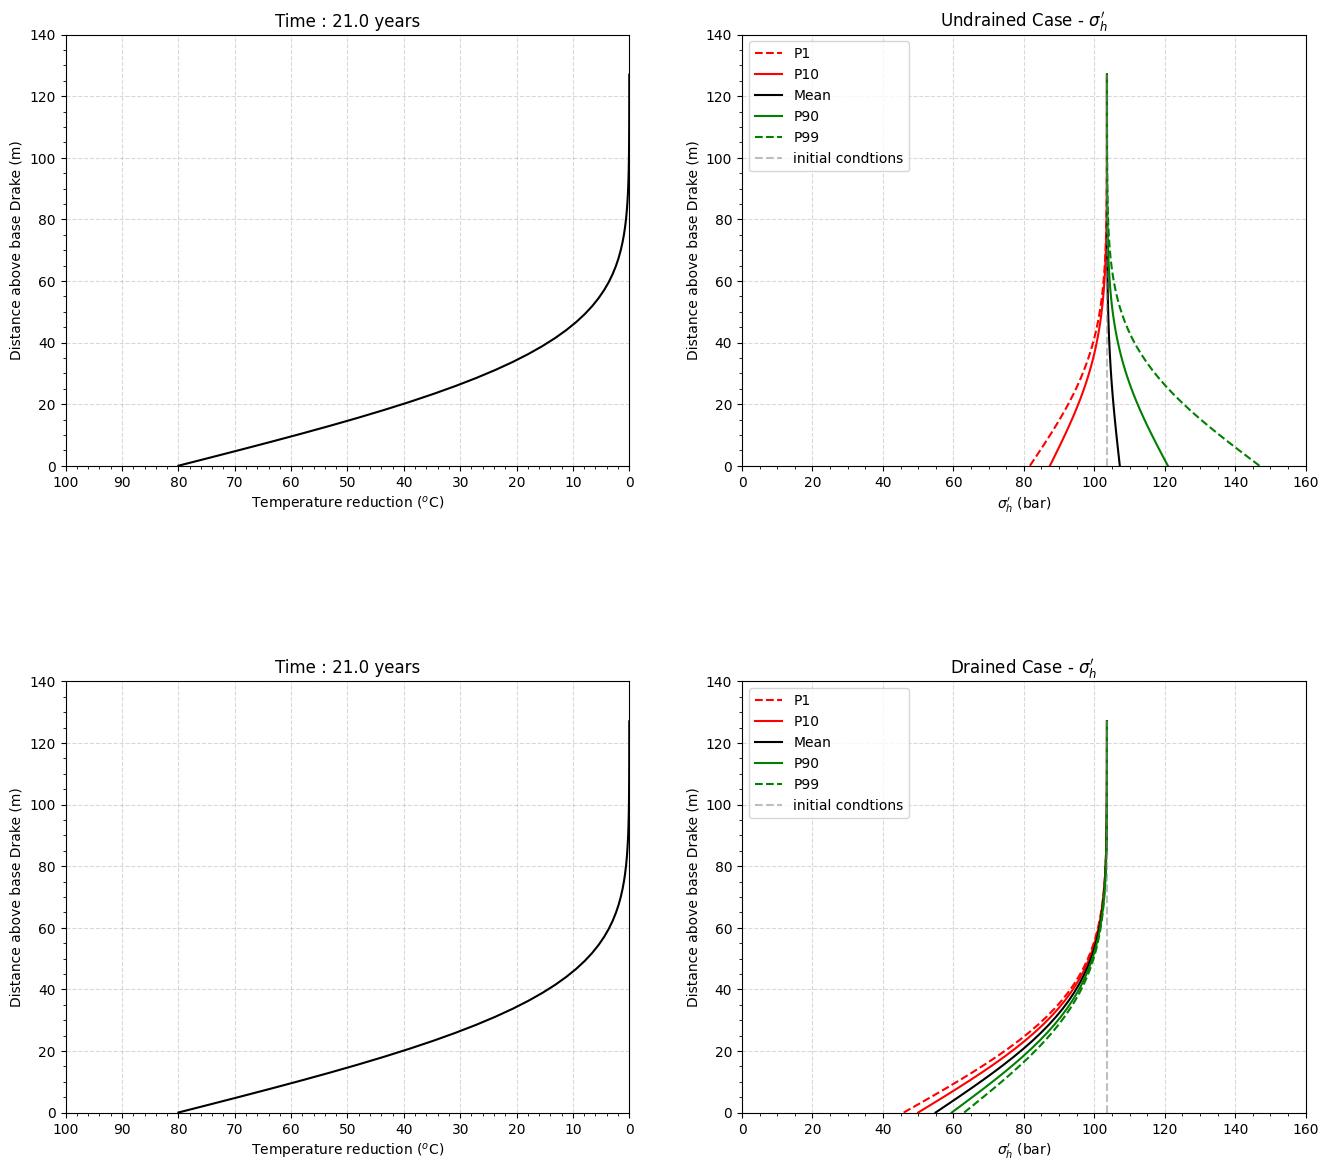

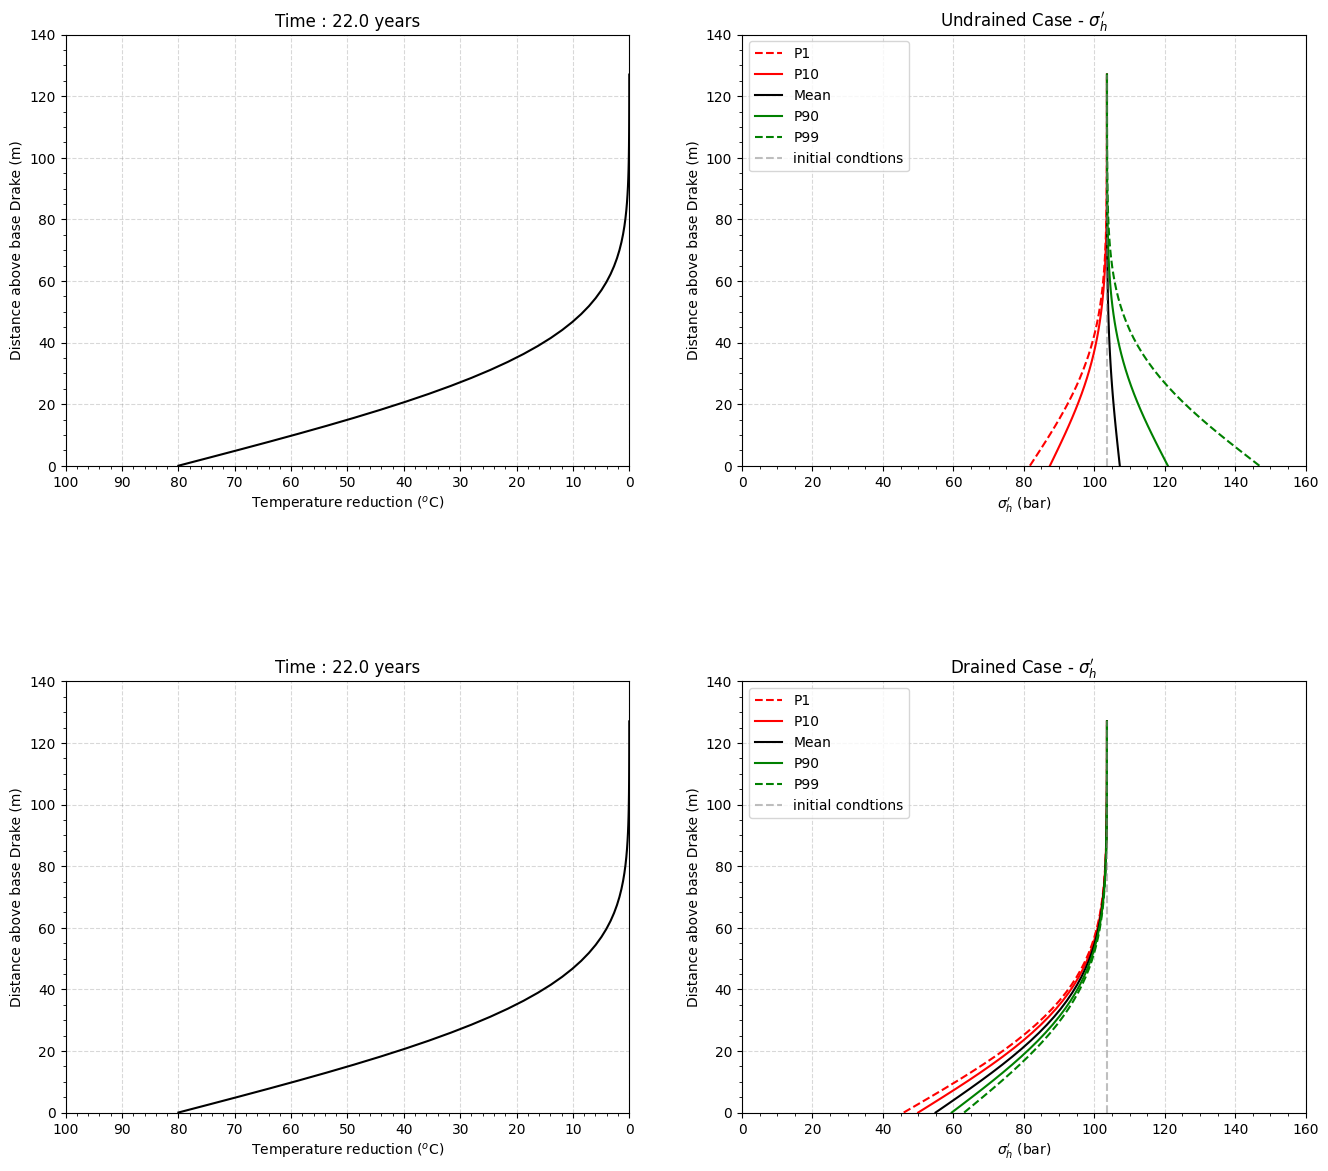

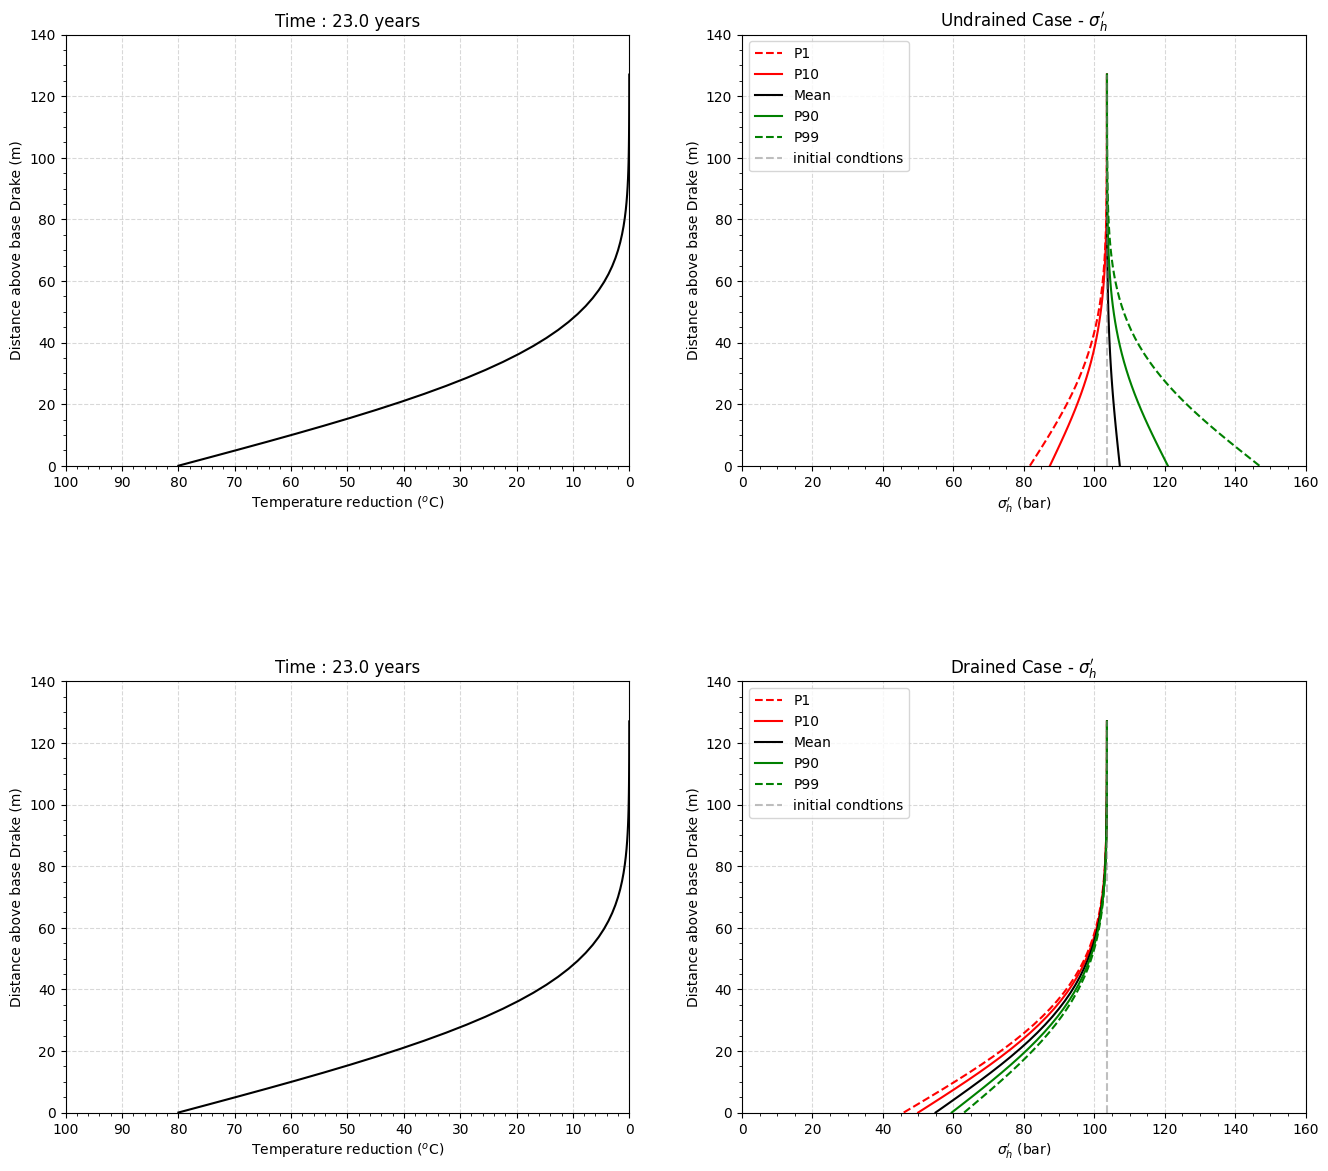

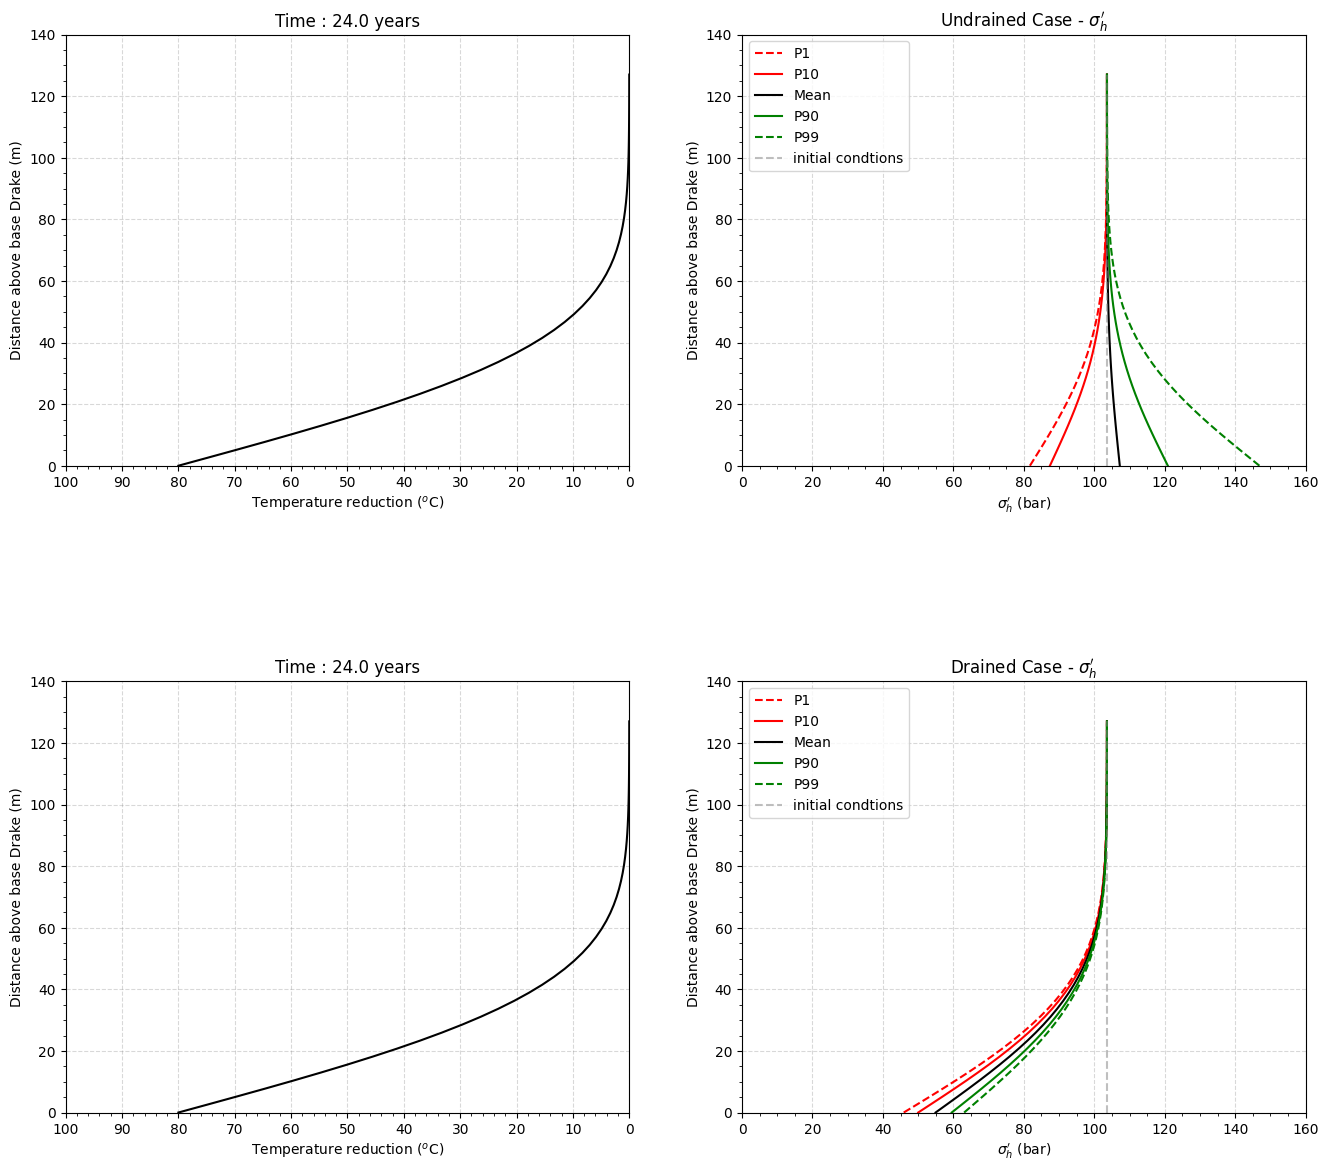

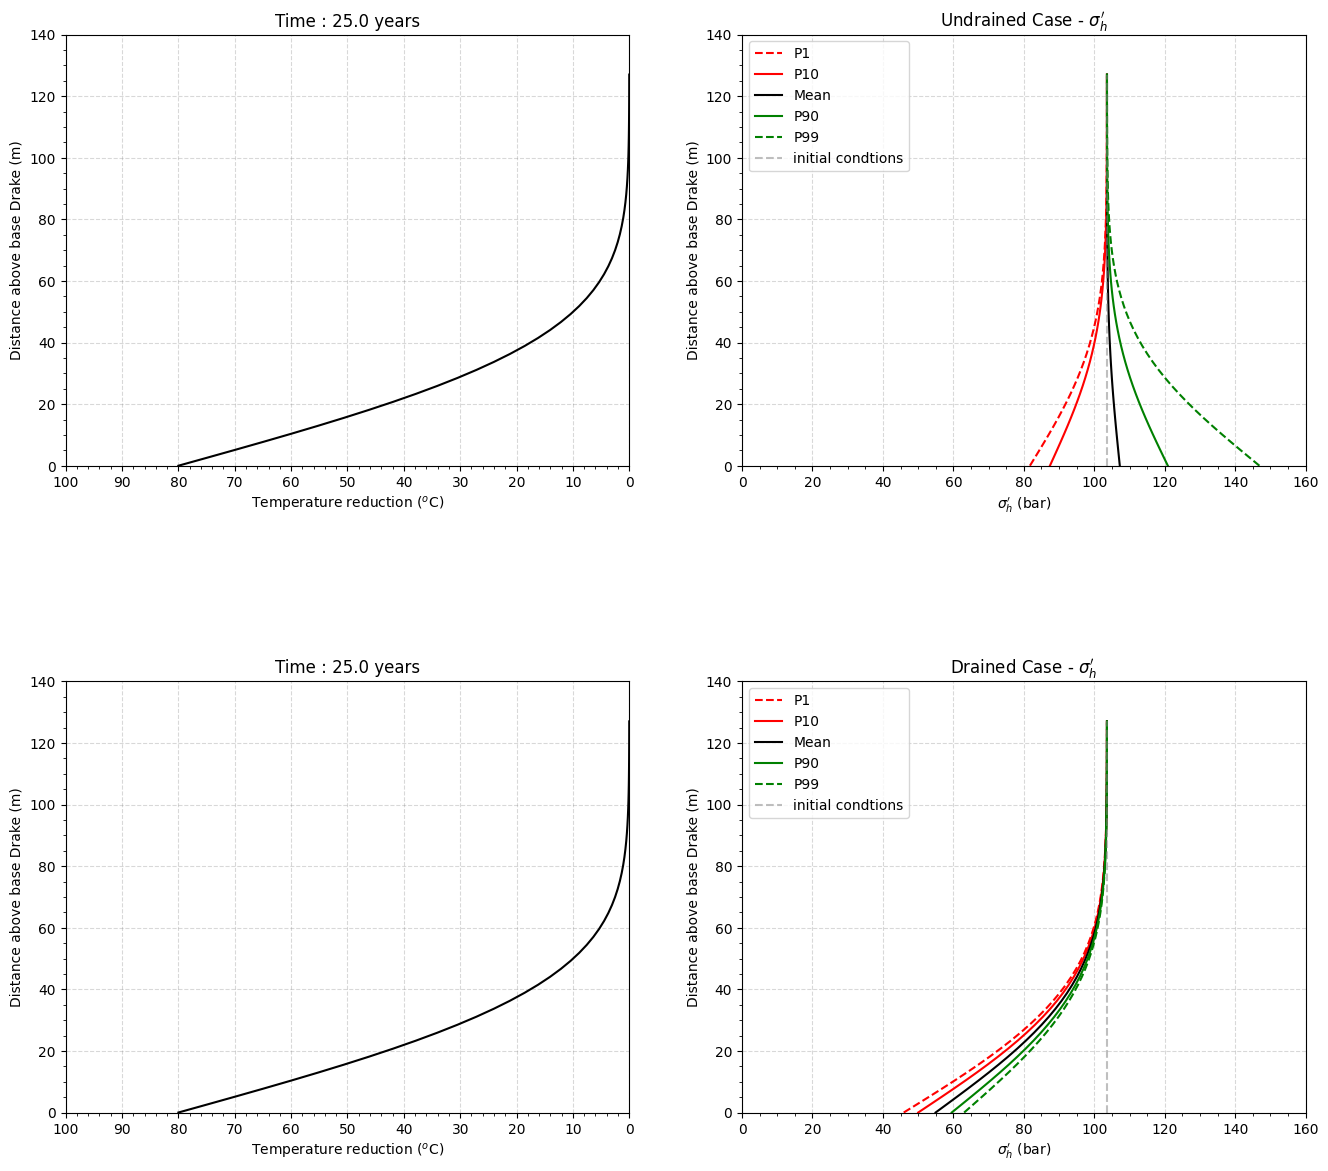

In [4]:
#Setting up file directory for saving the outputs
current_directory=os.getcwd()
out_directory=os.path.join(current_directory,"Results")
if not os.path.exists(out_directory): os.makedirs(out_directory)

#start time
start_time=time.time()
counter=0

for t in time_inj:
    #Setting up subplots for output
    fig,ax=plt.subplots(2,2,figsize=(16,14))
    plt.subplots_adjust(hspace=0.5)

    #formatting subplot 1 (ax[0,0])
    ax[0,0].set_xlim(100,0)
    ax[0,0].set_ylim(0,140)
    ax[0,0].grid(c='grey',ls='--',alpha=0.3)
    ax[0,0].set_ylabel('Distance above base Drake (m)')
    ax[0,0].set_xlabel('Temperature reduction ($^{o}$C)')
    ax[0,0].set_title('Time : '+str(t)+' years')
    ax[0,0].set_xticks([100,90,80,70,60,50,40,30,20,10,0])
    ax[0,0].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax[0,0].xaxis.set_minor_locator(ticker.MultipleLocator(2))

    #formatting subplot 2 (ax[0,1])
    ax[0,1].set_xlabel("$\sigma_{h}'$ (bar)")
    ax[0,1].set_ylabel("Distance above base Drake (m)")
    ax[0,1].set_title("Undrained Case - $\sigma_{h}'$")
    ax[0,1].set_xlim(0,160)
    ax[0,1].set_ylim(0,140)
    ax[0,1].grid(c='grey',ls='--',alpha=0.3)
    ax[0,1].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax[0,1].xaxis.set_minor_locator(ticker.AutoMinorLocator())

    #formatting subplot 3 (ax[1,0])
    ax[1,0].set_xlim(100,0)
    ax[1,0].set_ylim(0,140)
    ax[1,0].grid(c='grey',ls='--',alpha=0.3)
    ax[1,0].set_ylabel('Distance above base Drake (m)')
    ax[1,0].set_xlabel('Temperature reduction ($^{o}$C)')
    ax[1,0].set_title('Time : '+str(t)+' years')
    ax[1,0].set_xticks([100,90,80,70,60,50,40,30,20,10,0])
    ax[1,0].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax[1,0].xaxis.set_minor_locator(ticker.MultipleLocator(2))

    #formatting subplot 4 (ax[1,1])
    ax[1,1].set_xlabel("$\sigma_{h}'$ (bar)")
    ax[1,1].set_ylabel("Distance above base Drake (m)")
    ax[1,1].set_title("Drained Case - $\sigma_{h}'$")
    ax[1,1].set_xlim(0,160)
    ax[1,1].set_ylim(0,140)
    ax[1,1].grid(c='grey',ls='--',alpha=0.3)
    ax[1,1].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax[1,1].xaxis.set_minor_locator(ticker.AutoMinorLocator())

    #empty arrays for saving calculation results -> ud:drained case, dr:drained case
    ud_1=[]
    ud_10=[]
    ud_50=[]
    ud_90=[]
    ud_99=[]

    dr_1=[]
    dr_10=[]
    dr_50=[]
    dr_90=[]
    dr_99=[]
    
    #Calculating temperature profile at time t
    T_current=temp(htop,t,T_form,T_bhp,D)
    dT=T_form-T_current
    
    for del_t in dT:
        #undrained case
        res=ud_response(del_t,BT,Bf,Bs_vol,vfr,Efr,Por,Biot,Ks,cf)
        ud_res=res[0]
        pp_res=res[1]
        init=sh_ini-Ppi
        ud_1.append(init-np.percentile(ud_res,1)+np.percentile(pp_res,1))
        ud_10.append(init-np.percentile(ud_res,10)+np.percentile(pp_res,10))
        ud_50.append(init+np.percentile(ud_res,50)-np.percentile(pp_res,50))
        ud_90.append(init-np.percentile(ud_res,90)+np.percentile(pp_res,90))
        ud_99.append(init-np.percentile(ud_res,99)+np.percentile(pp_res,99))

        #drained case
        dr_res=dr_response(del_t,BT,vfr,Efr)
        dr_1.append(init-np.percentile(dr_res,99))
        dr_10.append(init-np.percentile(dr_res,90))
        dr_50.append(init-np.percentile(dr_res,50))
        dr_90.append(init-np.percentile(dr_res,10))
        dr_99.append(init-np.percentile(dr_res,1))
        
    #plotting results
    
    #subplot 1 (ax[0,0])
    ax[0,0].plot(dT,htop,c='k')
    
    #subplot 2 (ax[0,1])
    ax[0,1].plot(ud_1,htop,c='r',ls='--',label='P1')
    ax[0,1].plot(ud_10,htop,c='r',label='P10')
    ax[0,1].plot(ud_50,htop,c='k',label='Mean')
    ax[0,1].plot(ud_90,htop,c='green',label='P90')
    ax[0,1].plot(ud_99,htop,c='green',ls='--',label='P99')
    ax[0,1].plot([(sh_ini-Ppi),(sh_ini-Ppi)],[0,127],c='grey',ls='--',alpha=0.5,label='initial condtions')
    ax[0,1].legend(loc='upper left')
    
    #subplot 3 (ax[1,0])
    ax[1,0].plot(dT,htop,c='k')
    
    #subplot 4 (ax[1,1])
    ax[1,1].plot(dr_1,htop,c='r',ls='--',label='P1')
    ax[1,1].plot(dr_10,htop,c='r',label='P10')
    ax[1,1].plot(dr_50,htop,c='k',label='Mean')
    ax[1,1].plot(dr_90,htop,c='green',label='P90')
    ax[1,1].plot(dr_99,htop,c='green',ls='--',label='P99')
    ax[1,1].plot([(sh_ini-Ppi),(sh_ini-Ppi)],[0,127],c='grey',ls='--',alpha=0.5,label='initial condtions')
    ax[1,1].legend(loc='upper left')
    
    #Saving plots
    output_file=os.path.join(out_directory,str(counter)+'.png')
    plt.savefig(output_file)
    counter+=1
    
    #Time calculation
    progress = (t + 1) / len(time_inj)

    # Estimate remaining time
    elapsed_time = time.time() - start_time
    remaining_time = (1 - progress) * elapsed_time / progress

    # Print progress and remaining time
    print(f"Progress: {progress * 100:.2f}%, Remaining Time: {remaining_time:.2f} seconds", end='\r')

#End time
plt.ioff()
end_time=time.time()

Animation saved as results.gif


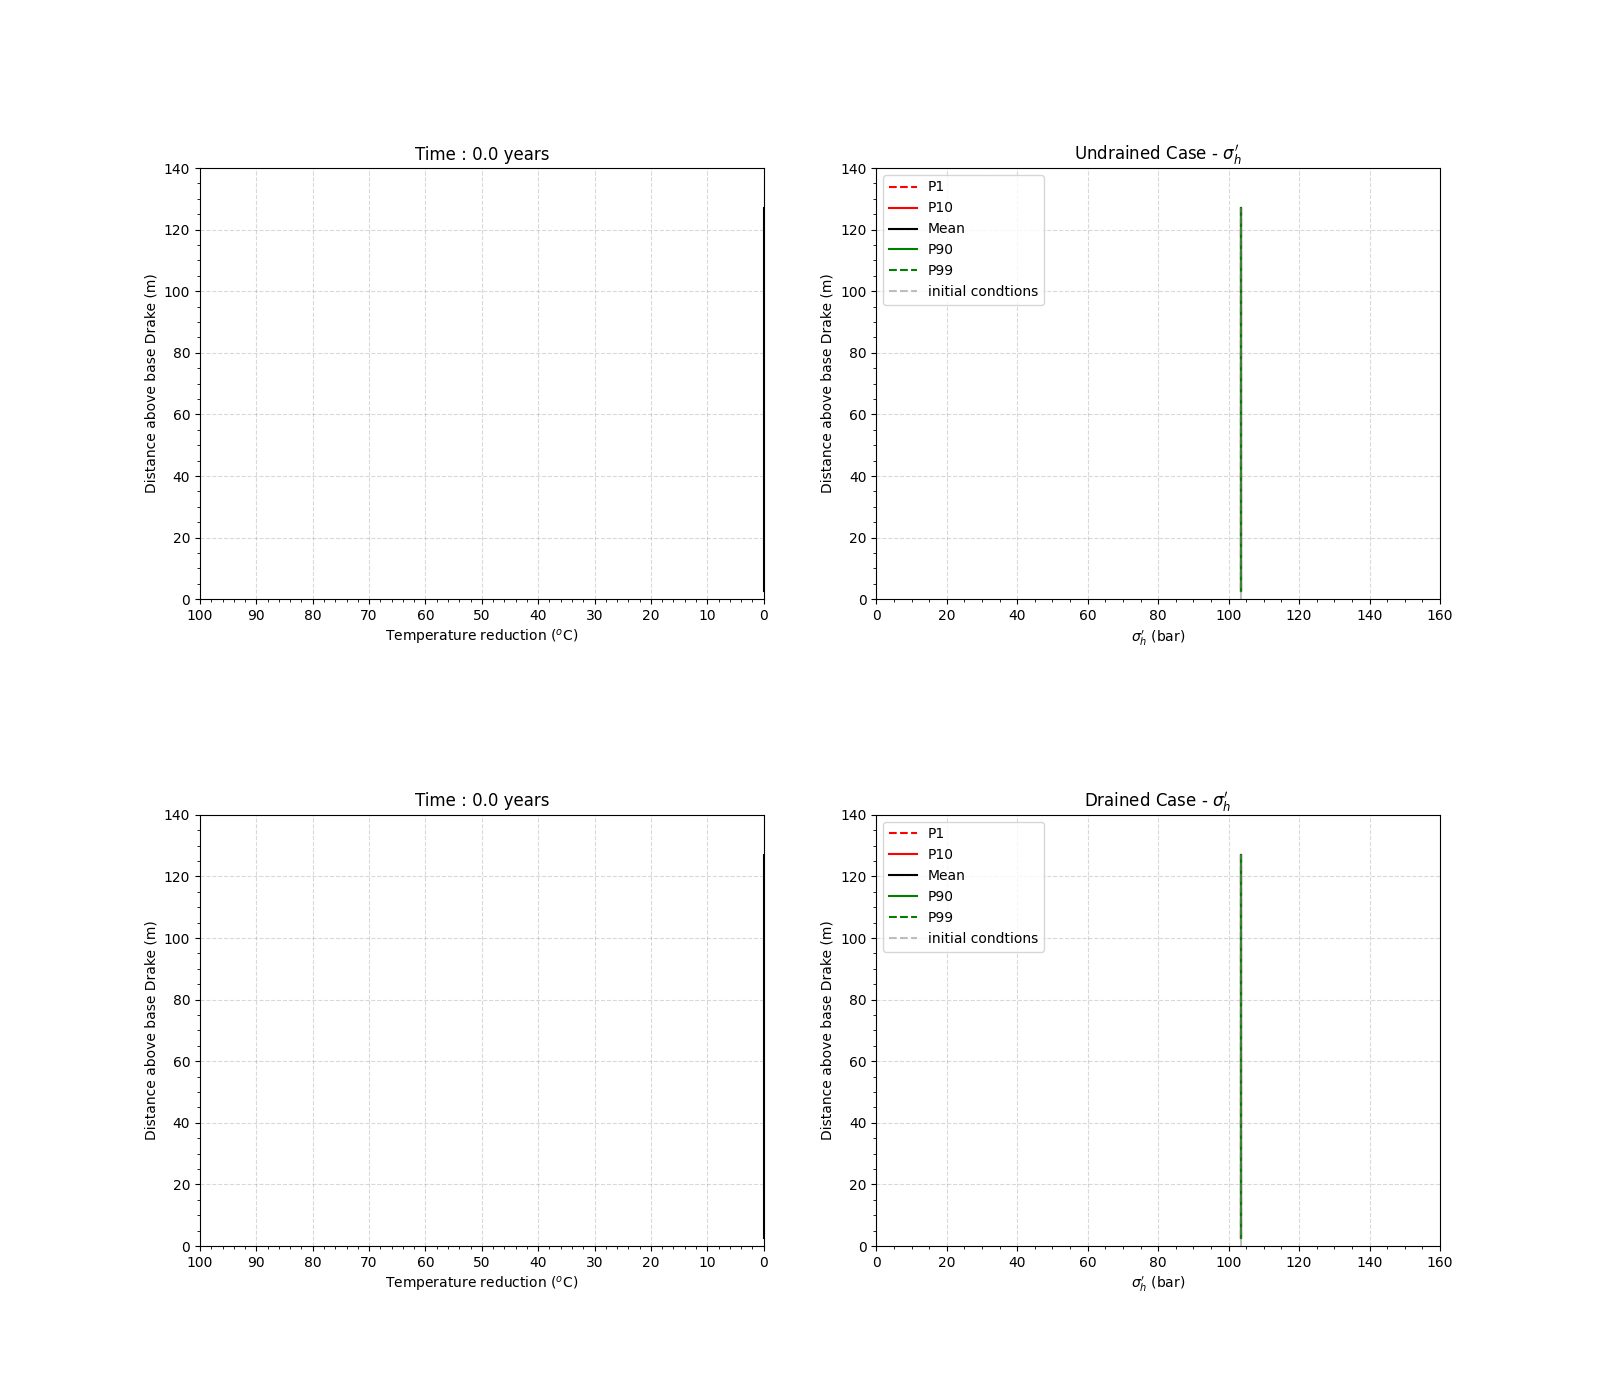

In [5]:
#Make an animation out of the saved images
gif_output='results.gif'

# Get a list of all PNG files in the directory
image_files = [f for f in os.listdir(out_directory) if f.endswith('.png')]
image_files.sort(key=lambda x: int(x.split('.')[0]))

# Create a list to store images
images = []

# Read each image and append to the list
for image_file in image_files:
    image_path = os.path.join(out_directory, image_file)
    images.append(imageio.imread(image_path))
    

# Create the animation
imageio.mimsave(gif_output, images, duration=0.2)  # Set duration between frames (in seconds)

print(f"Animation saved as {gif_output}")

display(Image(filename=gif_output))

### Vincent Indina, MS student, University of Texas at Austin 

Vincent is intensively conducting research on reservoir simulations of carbon capture and storage (CCS) under Dr. Kamy Sepehrnoori's supervision. He is very interested in data analytics and eagerly looking for a full-time/internship position to work with the industry.
##### [LinkedIn](https://www.linkedin.com/in/vincentindina)